<style>
    .title_container {
        margin: auto;
        background: rgb(81,92,103);
        background: linear-gradient(90deg, rgba(81,92,103,1) 36%, rgba(12,35,66,1) 62%);
        border-radius: 7px;
        color: white;
        text-align:center;
        width:75%;
        padding-top:2%;
        padding-bottom:2%;
    }
    
    .question_container {
        margin: auto;
        background: rgb(84,138,142);
        background: linear-gradient(90deg, rgba(84,138,142,1) 41%, rgba(145,201,73,1) 81%);
        border-radius: 7px;
        color: white;
        text-align:left;
        width:75%;
        padding-top:1%;
        padding-bottom:1%;
        padding-left: 2%;
        margin-top:2%;
    }
    
    .question_container p {
        font-size: 16px;
    }
    
    .code_span {
        background-color: #E2E7EC;
        padding:2px;
        border-radius:1px;
        font-family: Consolas,monaco,monospace;
        color:black;
    }
</style>

<div class ='title_container'>
    <h1> Análisis de Datos II </h1>
    <h2> Profesor: Oldemar Rodríguez </h2>
    <h3> Estudiante: Jimmy Calvo Monge </h3>
    <h3> Carné: B31281 </h3>
    <hr style='color:white; width:80%;'>
    <h4> TAREA 3 </h4>
    <h4> Fecha de entrega: 11 de Setiembre de 2022 </h4>
</div>

Importamos los módulos necesarios para resolver esta tarea.

In [108]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sn
import math

In [2]:
def indices_general(MC, nombres = None):
    precision_global = np.sum(MC.diagonal()) / np.sum(MC)
    error_global     = 1 - precision_global
    precision_categoria  = pd.DataFrame(MC.diagonal()/np.sum(MC,axis = 1)).T
    if nombres!=None:
        precision_categoria.columns = nombres
    return {"Matriz de Confusión":MC, 
            "Precisión Global":   precision_global, 
            "Error Global":       error_global, 
            "Precisión por categoría":precision_categoria}

import matplotlib.ticker as mticker

def distribucion_variable_predecir(data:pd.DataFrame,variable_predict:str, ax = None):
    if ax == None:
        fig, ax = plt.subplots(1,1, figsize = (15,10), dpi = 200)
    colors = list(dict(**mcolors.CSS4_COLORS))
    df = pd.crosstab(index = data[variable_predict],columns = "valor") / data[variable_predict].count()
    countv = 0
    titulo = "Distribución de la variable %s" % variable_predict
    
    for i in range(df.shape[0]):
        ax.barh(1, df.iloc[i], left = countv, align = 'center', color = colors[11 + i], label = df.iloc[i].name)
        countv = countv + df.iloc[i]
        
    ax.set_xlim(0,1)
    ax.set_yticklabels("")
    ax.set_ylabel(variable_predict)
    ax.set_title(titulo)
    ticks_loc = ax.get_xticks().tolist()
    ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
    ax.set_xticklabels(['{:.0%}'.format(x) for x in ticks_loc])
    
    countv = 0
    for v in df.iloc[:,0]:
        ax.text(np.mean([countv, countv + v]) - 0.03, 1 , '{:.1%}'.format(v), color = 'black', fontweight = 'bold')
        countv = countv + v
    ax.legend(loc = 'upper center', bbox_to_anchor = (1.08, 1), shadow = True, ncol = 1)
    
def poder_predictivo_categorica(data: pd.DataFrame, var: str, variable_predict: str, ax=None):
    if ax == None:
        fig, ax = plt.subplots(1, 1, figsize = (15, 10), dpi = 200)
    df = pd.crosstab(index = data[var], columns = data[variable_predict])
    df = df.div(df.sum(axis = 1), axis = 0)
    titulo = "Distribución de la variable %s según la variable %s" % (var, variable_predict)
    df.plot(kind = 'barh', stacked = True,   legend = True, ax = ax,
            xlim = (0, 1), title   = titulo, width = 0.8)
            
    ticks_loc = ax.get_xticks().tolist()
    ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
    ax.set_xticklabels(['{:.0%}'.format(x) for x in ticks_loc])
    ax.legend(loc = 'upper center', bbox_to_anchor = (1.08, 1), 
              shadow = True, ncol = 1)
              
    for bars in ax.containers:
        plt.setp(bars, width = .9)
    for i in range(df.shape[0]):
        countv = 0
        for v in df.iloc[i]:
            ax.text(np.mean([countv, countv+v]) - 0.03, i,
                    '{:.1%}'.format(v), color = 'black', fontweight = 'bold')
            countv = countv + v
            
def poder_predictivo_numerica(data:pd.DataFrame, var:str, variable_predict:str):
    sns.FacetGrid(data, hue = variable_predict, height = 8, aspect = 1.8).map(sns.kdeplot, var, shade = True).add_legend()

<div class='question_container'>
    <h2> Pregunta 1 </h2>
    <p> Dada la siguiente Tabla de Testing de un Scoring de Crédito: </p>
    <ol>
        <li> Usando la columna BuenPagador en donde aparece el verdadero valor de la variable a predecir y la columna Predicción KNN en donde aparece la predicción del Método KNN para esta tabla de Testing, calcule la Matriz de Confusión. </li>
        <li> Con la Matriz de Confusión anterior calcule 'a mano' la Precisión Global, el Error Global, la Precisión Positiva (PP), la Precisión Negativa (PN), la Proporción de Falsos Positivos (PFP), la Proporción de Falsos Negativos (PFN), la Asertividad Positiva (AP) y la Asertividad Negativa (AN). </li>  
    </ol>
</div>

**Respuesta:** Voy a guardar las columnas `BuenPagador` y `PrediccionKNN` para calcular la matriz de confusión de este modelo. (Son las únicas columnas que se necesitan).

In [3]:
Datos=pd.DataFrame({
    'BuenPagador':['Si']*19 + ['No']*6,
    'PrediccionKNN':['Si','No']+['Si']*6 + ['No'] + ['Si']*10 + ['No']*2+ ['Si']*2 + ['No']*2
})
Datos

,BuenPagador,PrediccionKNN
0,Si,Si
1,Si,No
2,Si,Si
3,Si,Si
4,Si,Si
5,Si,Si
6,Si,Si
7,Si,Si
8,Si,No
9,Si,Si


Podemos calcular la matriz de confusion en `Python` utilizando la biblioteca `sklearn`.

In [4]:
mat_cfn = metrics.confusion_matrix(Datos['BuenPagador'], Datos['PrediccionKNN'])

In [5]:
mat_cfn

array([[ 4,  2],
       [ 2, 17]], dtype=int64)

En efecto, revisamos que los cálculos son correctos:

In [6]:
VP = Datos[(Datos['BuenPagador']=='Si') & (Datos['PrediccionKNN']=='Si')].shape[0]
VN = Datos[(Datos['BuenPagador']=='No') & (Datos['PrediccionKNN']=='No')].shape[0]
FP = Datos[(Datos['BuenPagador']=='No') & (Datos['PrediccionKNN']=='Si')].shape[0]
FN = Datos[(Datos['BuenPagador']=='Si') & (Datos['PrediccionKNN']=='No')].shape[0]

dict_prec = {
    'VP':VP,
    'VN':VN,
    'FP':FP,
    'FN':FN
}
print(dict_prec)

{'VP': 17, 'VN': 4, 'FP': 2, 'FN': 2}


Los cálculos que nos solicita el ejercicio entonces son los siguientes:

In [7]:
dict_medidas = {
    'Precisión Global' : (VN+VP)/(VN+FP+FN+VP),
    'Error Global' : (FN+FP)/(VN+FP+FN+VP),
    'Precisión Positiva (PP)' : VP/(FN+VP),
    'Precisión Negativa (PN)' : VN/(VN+FP),
    'Proporción de Falsos Positivos (PFP)' : FP/(VN+FP),
    'Proporción de Falsos Negativos (PFN)' : FN/(FN+VP),
    'Asertividad Positiva (AP)' : VP/(FP+VP),
    'Asertividad Negativa (AN)' : VN/(VN+FN)
}

print("Estos son los resultados para la pregunta 1:")

for key in list(dict_medidas.keys()):
    print(f" - {key}: {dict_medidas[key]}")

Estos son los resultados para la pregunta 1:
 - Precisión Global: 0.84
 - Error Global: 0.16
 - Precisión Positiva (PP): 0.8947368421052632
 - Precisión Negativa (PN): 0.6666666666666666
 - Proporción de Falsos Positivos (PFP): 0.3333333333333333
 - Proporción de Falsos Negativos (PFN): 0.10526315789473684
 - Asertividad Positiva (AP): 0.8947368421052632
 - Asertividad Negativa (AN): 0.6666666666666666


<div class='question_container'>
    <h2> Pregunta 2 </h2>
    <p> Programe en lenguaje `Python` una clase que contenga un método que reciba como entrada la Matriz de Confusión (para el caso 2 $\times$ 2) que calcule y retorne en un diccionario: la Precisión Global, el Error Global, la Precisión Positiva (PP), la Precisión Negativa (PN), la Proporción de Falsos Positivos (PFP), la Proporción de Falsos Negativos (PFN), la Asertividad Positiva (AP) y la Asertividad Negativa (AN). </p>
    <p> Supongamos que tenemos un modelo predictivo para detectar Fraude en Tarjetas de Crédito, la variable a predecir es Fraude con dos posibles valores Sí (para el caso en que sí fue fraude) y No (para el caso en que no fue fraude). Supongamos que la matriz de confusión es: </p>
    <table>
        <tr>
            <th></th>
            <th>No</th>
            <th>Sí</th>
        </tr>
        <tr>
            <td>No</td>
            <td>892254</td>
            <td>252</td>
        </tr>
        <tr>
            <td>Sí</td>
            <td>9993</td>
            <td>270</td>
        </tr>
    </table>
    <ul>
        <li> Con ayuda de la clase programada anteriormente calcule la Precisión Global, el Error Global, la Precisión Positiva (PP), la Precisión Negativa (PN), la Proporción de Falsos Positivos (PFP), la Proporción de Falsos Negativos (PFN), la Asertividad Positiva (AP) y la Asertividad Negativa (AN). </li>
        <li> ¿Es bueno o malo el modelo predictivo? Justifique su respuesta. </li>
    </ul>
</div>

In [8]:
class MatConf:
    
    def __init__(self,matriz):
        
        self.mat_conf = matriz
        
        VN = self.mat_conf[0,0]
        VP = self.mat_conf[1,1]
        FP = self.mat_conf[0,1]
        FN = self.mat_conf[1,0]
        
        dict_medidas = {
            'Precisión Global' : (VN+VP)/(VN+FP+FN+VP),
            'Error Global' : (FN+FP)/(VN+FP+FN+VP),
            'Precisión Positiva (PP)' : VP/(FN+VP),
            'Precisión Negativa (PN)' : VN/(VN+FP),
            'Proporción de Falsos Positivos (PFP)' : FP/(VN+FP),
            'Proporción de Falsos Negativos (PFN)' : FN/(FN+VP),
            'Asertividad Positiva (AP)' : VP/(FP+VP),
            'Asertividad Negativa (AN)' : VN/(VN+FN)
        }
        self.dict_medidas = dict_medidas
        
    def __str__(self):
        mensaje="Estos son los resultados para esta matriz de confusion:"
        for key in list(self.dict_medidas.keys()):
            mensaje = mensaje + f"\n - {key}: {self.dict_medidas[key]}"
        return mensaje

In [9]:
cfn_mat =np.matrix([[892254,252],[9993,270]])
cfn_mat_obj = MatConf(cfn_mat)
print(cfn_mat_obj.__str__())

Estos son los resultados para esta matriz de confusion:
 - Precisión Global: 0.9886515819661508
 - Error Global: 0.01134841803384919
 - Precisión Positiva (PP): 0.026308097047646885
 - Precisión Negativa (PN): 0.9997176489569818
 - Proporción de Falsos Positivos (PFP): 0.0002823510430181982
 - Proporción de Falsos Negativos (PFN): 0.9736919029523531
 - Asertividad Positiva (AP): 0.5172413793103449
 - Asertividad Negativa (AN): 0.9889243189503539


##### Observaciones: 

- Note que se trata de un problema no balanceado, con una gran cantidad de Negativos.
- En mi opinión personal diría que este modelo es no es bueno. Claramente sobre los Negativos tenemos un muy buen comportamiento, pero esto se debe al desbalance de las clases. Sin embargo las notas bajan sobre los Positivos, vea que hay una alta proporción de falsos negativos, y la precisión negativa es muy baja, y la asertividad negativa es cercana al 50%.

<div class='question_container'>
    <h2> Pregunta 3 </h2>
    <p> En este ejercicio usaremos la tabla de datos abandono clientes.csv, que contiene los detalles de los clientes de un banco. </p>
    <p> La tabla contiene 11 columnas (variables), las cuales se explican a continuación. </p>
    <ul>
        <li> <span class='code_span'> CreditScore </span>: Indica el puntaje de crédito. </li>
        <li> <span class='code_span'>Geography</span>: País al que pertenece.</li>
        <li> <span class='code_span'>Gender</span>: Género del empleado.</li>
        <li> <span class='code_span'>Age</span>: Edad del empleado.</li>
        <li> <span class='code_span'>Tenure</span>: El tiempo del vínculo con la empresa.</li>
        <li> <span class='code_span'>Balance</span>: La cantidad que les queda.</li>
        <li> <span class='code_span'>NumOfProducts</span>: Los productos que posee.</li>
        <li> <span class='code_span'>HasCrCard</span>: Tienen tarjeta de crédito o no.</li>
        <li> <span class='code_span'>IsActiveMember</span>: Es un miembro activo o no.</li>
        <li> <span class='code_span'>EstimatedSalary</span>: Salario estimado.</li>
        <li> <span class='code_span'>Exited</span>: Indica si el cliente se queda o se va.</li>
    </ul>
    <p> Realice lo siguiente: </p>
    <ol>
        <li> Cargue en <span class='code_span'>Python</span> la tabla de datos <span class='code_span'>abandono_clientes.csv</span>.</li>
        <li> ¿Es este problema equilibrado o desequilibrado? Justifique su respuesta.</li>
        <li> Use el método de K vecinos más cercanos en <span class='code_span'>Python</span> para generar un modelo predictivo para la tabla abandono clientes.csv usando el 75% de los datos para la tabla aprendizaje y un 25% para la tabla testing. Intente con varios valores de K e indique cuál fue la mejor opción.</li>
        <li> Genere un Modelo Predictivo usando K vecinos más cercanos para cada uno de los siguientes núcleos <span class='code_span'>ball_tree</span>, <span class='code_span'>kd_tree</span> y <span class='code_span'>brute</span> ¿Cuál produce los mejores resultados en el sentido de que predice mejor?</li>
    </ol>
</div>

In [10]:
df_clientes = pd.read_csv("abandono_clientes.csv")
df_clientes = df_clientes.drop(['Unnamed: 0'], axis=1)
df_clientes

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,Si,Si,101348.88,Si
1,608,Spain,Female,41,1,83807.86,1,No,Si,112542.58,No
2,502,France,Female,42,8,159660.80,3,Si,No,113931.57,Si
3,699,France,Female,39,1,0.00,2,No,No,93826.63,No
4,850,Spain,Female,43,2,125510.82,1,Si,Si,79084.10,No
...,...,...,...,...,...,...,...,...,...,...,...
5175,609,France,Male,41,6,0.00,1,No,Si,112585.19,No
5176,518,France,Male,42,7,151027.05,2,Si,No,119377.36,No
5177,833,France,Female,34,3,144751.81,1,No,No,166472.81,No
5178,774,France,Male,40,9,93017.47,2,Si,No,191608.97,No


In [11]:
df_clientes.dtypes

CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard           object
IsActiveMember      object
EstimatedSalary    float64
Exited              object
dtype: object

Con el siguiente gráfico nos damos cuenta que en efecto estamos tratando con un problema moderadamente desbalanceado, ya que hay 80% de 'No's y un minoritario 20% de 'Si's.

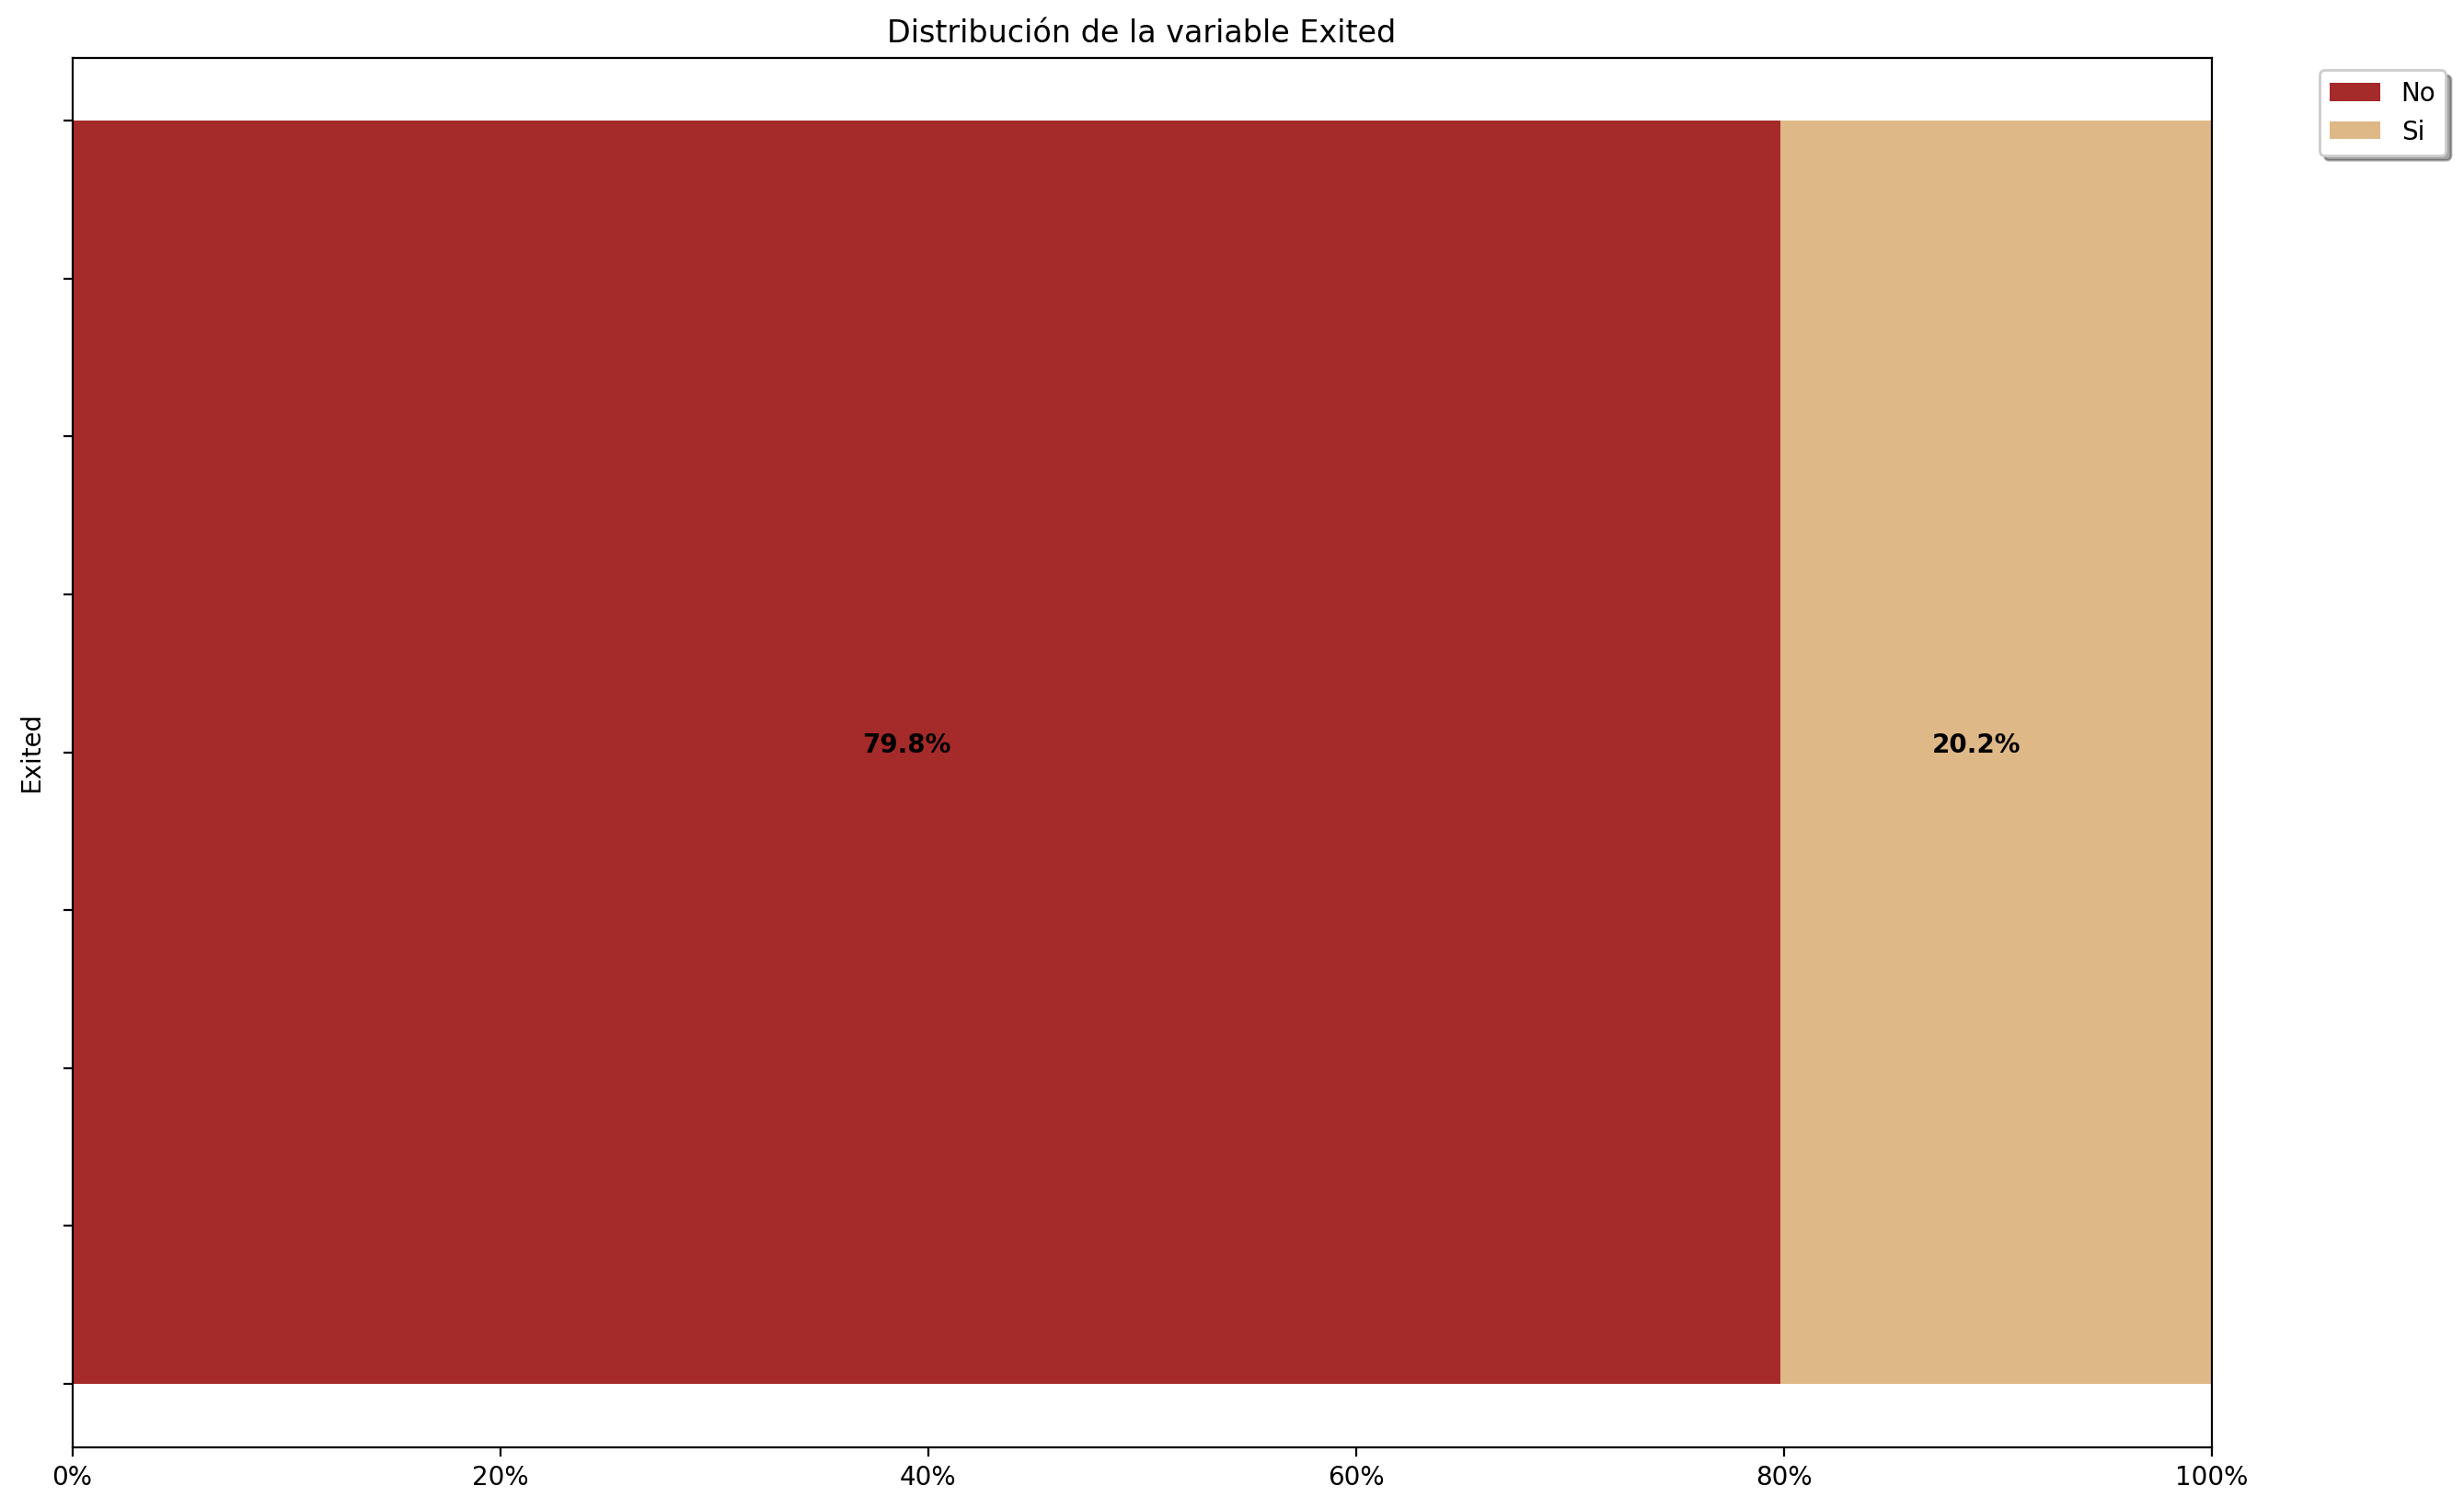

In [12]:
distribucion_variable_predecir(df_clientes,"Exited")
plt.show()

Preparación de los datos

In [13]:
# Convierte las variables a categórica
columnas_cat= [col for col in df_clientes.columns if str(df_clientes.dtypes[col]) =='object' and col!='Exited' ] ### Columnas predictivas y string
for col in columnas_cat:
    df_clientes[col] = df_clientes[col].astype('category')
    
# Variable a predecir
y = df_clientes["Exited"].ravel()

#Convertimos a Dummy algunas de las variables predictoras
X = pd.get_dummies(df_clientes.drop(columns=["Exited"]), columns=columnas_cat)

#Estandarizamos los datos
X = pd.DataFrame(StandardScaler().fit_transform(X), columns=[X.columns])
X.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,HasCrCard_No,HasCrCard_Si,IsActiveMember_No,IsActiveMember_Si
0,-0.329766,0.309304,-1.050847,-1.232685,-0.929094,0.013390,0.989247,-0.576459,-0.569919,1.102099,-1.102099,-0.643238,0.643238,-0.974457,0.974457
1,-0.443101,0.212530,-1.397493,0.109742,-0.929094,0.209135,-1.010870,-0.576459,1.754634,1.102099,-1.102099,1.554634,-1.554634,-0.974457,0.974457
2,-1.535235,0.309304,1.029031,1.324747,2.550810,0.233425,0.989247,-0.576459,-0.569919,1.102099,-1.102099,-0.643238,0.643238,1.026212,-1.026212
3,0.494485,0.018981,-1.397493,-1.232685,0.810858,-0.118152,0.989247,-0.576459,-0.569919,1.102099,-1.102099,1.554634,-1.554634,1.026212,-1.026212
4,2.050261,0.406078,-1.050847,0.777736,-0.929094,-0.375956,-1.010870,-0.576459,1.754634,1.102099,-1.102099,-0.643238,0.643238,-0.974457,0.974457


Split de Train y Testing

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.75)

Para cada `k` entre 1 y 10 vamos a ajustar un modelo de `k` vecinos e imprimiremos la evaluación sobre los datos de prueba.

In [15]:
for k in range(1,11):
    
    print(f" Modelo de k vecinos para k = {k} :")
    
    instancia_knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
    instancia_knn.fit(X_train.values,y_train)
    
    prediccion = instancia_knn.predict(X_test.values)

    labels = ["No","Si"]
    MC = confusion_matrix(y_test, prediccion, labels=labels)

    indices = indices_general(MC,labels)
    for r in indices:
        print("\n%s:\n%s"%(k,str(indices[r])))
        
    print("----------------------------------------------")

 Modelo de k vecinos para k = 1 :

1:
[[921 111]
 [154 109]]

1:
0.7953667953667953

1:
0.20463320463320467

1:
         No        Si
0  0.892442  0.414449
----------------------------------------------
 Modelo de k vecinos para k = 2 :

2:
[[1003   29]
 [ 210   53]]

2:
0.8154440154440155

2:
0.18455598455598454

2:
         No        Si
0  0.971899  0.201521
----------------------------------------------
 Modelo de k vecinos para k = 3 :

3:
[[964  68]
 [160 103]]

3:
0.8239382239382239

3:
0.1760617760617761

3:
         No        Si
0  0.934109  0.391635
----------------------------------------------
 Modelo de k vecinos para k = 4 :

4:
[[1003   29]
 [ 198   65]]

4:
0.8247104247104247

4:
0.17528957528957534

4:
         No        Si
0  0.971899  0.247148
----------------------------------------------
 Modelo de k vecinos para k = 5 :

5:
[[979  53]
 [172  91]]

5:
0.8262548262548263

5:
0.17374517374517373

5:
         No        Si
0  0.948643  0.346008
-------------------------

#### Observaciones:
Note que la mayoría de modelos se comportan similar, y todos tienen una buena predicción sobre la clase del 'No'. Debido al desbalance de las clases esto es esperado. Para juzgarlos más bien deberíamos ver a la clase del 'Si', sobre la cual se genera una mejor precisión si $k=1$ (por lo menos para esta simulación y para esta partición de los datos).

Intentemos ahora probar con los núcleos que nos da el enunciado. Para ver qué sucede haremos un rango de `k` y de los núcleos propuestos. Como el problema es desbalanceado voy a a calcular la precisión sobre los Si's para cada combinación.

In [16]:
datos_nucleos = pd.DataFrame({'k':[],'nucleo':[],'precision_positivos':[]})
nucleos = ['auto','ball_tree', 'kd_tree', 'brute']

for k in range(1,11):
    for nucleo in nucleos:
        
        instancia_knn = KNeighborsClassifier(n_neighbors=k,algorithm=nucleo)
        instancia_knn.fit(X_train.values,y_train)
        
        prediccion = instancia_knn.predict(X_test.values)
        MC = confusion_matrix(y_test, prediccion, labels=labels)
        
        indices = indices_general(MC,labels)
        prec_pos = indices['Precisión por categoría']['Si'][0]
         
        datos_nucleos = datos_nucleos.append(pd.DataFrame({'k':[k],'nucleo':[nucleo],'precision_positivos':[prec_pos]}))
        
datos_nucleos

,k,nucleo,precision_positivos
0,1.0,auto,0.414449
0,1.0,ball_tree,0.414449
0,1.0,kd_tree,0.414449
0,1.0,brute,0.414449
0,2.0,auto,0.201521
0,2.0,ball_tree,0.201521
0,2.0,kd_tree,0.201521
0,2.0,brute,0.201521
0,3.0,auto,0.391635
0,3.0,ball_tree,0.391635


Por alguna razón no estoy teniendo resultados diferentes al utilizar los núcleos. He revisado mi código y parece que todo está bien, pero apreciaría mucho una observación!

Aquí una verificación con dos variables distintas.

In [17]:
instancia_knn1 = KNeighborsClassifier(n_neighbors=5)
instancia_knn1.fit(X_train.values,y_train)
prediccion1 = instancia_knn1.predict(X_test.values)
MC1 = confusion_matrix(y_test, prediccion1, labels=labels)
indices1 = indices_general(MC1,labels)
print(indices1)

{'Matriz de Confusión': array([[979,  53],
       [172,  91]], dtype=int64), 'Precisión Global': 0.8262548262548263, 'Error Global': 0.17374517374517373, 'Precisión por categoría':          No        Si
0  0.948643  0.346008}


In [18]:
instancia_knn2 = KNeighborsClassifier(n_neighbors=5,algorithm='kd_tree')
instancia_knn2.fit(X_train.values,y_train)
prediccion2 = instancia_knn2.predict(X_test.values)
MC2 = confusion_matrix(y_test, prediccion2, labels=labels)
indices2 = indices_general(MC2,labels)
print(indices2)

{'Matriz de Confusión': array([[979,  53],
       [172,  91]], dtype=int64), 'Precisión Global': 0.8262548262548263, 'Error Global': 0.17374517374517373, 'Precisión por categoría':          No        Si
0  0.948643  0.346008}


Me da igual en ambos casos.

<div class='question_container'>
    <h2> Pregunta 4 </h2>
    <p> En este ejercicio vamos a usar la tabla de datos <span class='code_span'>raisin.csv</span>, que contiene el resultado de un sistema de visión artificial para distinguir entre dos variedades diferentes de pasas (Kecimen y Besni) cultivadas en Turquía. Estas imágenes se sometieron a varios pasos de preprocesamiento y se realizaron 7 operaciones de extracción de características morfológicas utilizando técnicas de procesamiento de imágenes. </p>
    <p>El conjunto de datos tiene 900 filas y 8 columnas las cuales se explican a continuación:</p>
    <ul>
        <li><span class='code_span'>Area</span> El número de píxeles dentro de los límites de la pasa. </li>
        <li><span class='code_span'>MajorAxisLength</span> La longitud del eje principal, que es la línea más larga que se puede dibujar en la pasa. </li>
        <li><span class='code_span'>MinorAxisLength</span> La longitud del eje pequeño, que es la línea más corta que se puededibujar en la pasa. </li>
        <li><span class='code_span'>Eccentricityl</span> Una medida de la excentricidad de la elipse, que tiene los mismos momentos que las pasas. </li>
        <li><span class='code_span'>ConvexArea</span> El número de píxeles de la capa convexa más pequeña de la región formada por la pasa. </li>
        <li><span class='code_span'>Extent</span> La proporción de la región formada por la pasa al total de píxeles en el cuadro delimitador. </li>
        <li><span class='code_span'>Perimeter</span> Mide el entorno calculando la distancia entre los límites de la pasa y los píxeles que la rodean. </li>
        <li><span class='code_span'>Class</span> Tipo de pasa Kecimen y Besni (Variable a predecir). </li>
    </ul>
    <p> Realice lo siguiente: </p>
    <ol>
        <li> Cargue en <span class='code_span'>Python</span> la tabla de datos <span class='code_span'>raisin.csv</span>. </li>
        <li> Realice un análisis exploratorio (estadísticas básicas) que incluya: el resumen numérico (media, desviación estándar, etc.), la correlación entre las variables, el poder predictivo de las variables predictoras. Interprete los resultados. </li>
        <li> ¿Es este problema equilibrado o desequilibrado? Justifique su respuesta. </li>
        <li> Use el método de K vecinos más cercanos en <span class='code_span'>Python</span> (con los parámetros por defecto) para generar un modelo predictivo para la tabla raisin.csv usando el 75% de los datos para la tabla aprendizaje y un 25% para la tabla testing, luego calcule para los datos de testing la matriz de confusión, la precisión global y la precisión para cada una de las dos categorías. ¿Son buenos los resultados? Explique. </li>
        <li> Repita el item 4), pero esta vez, seleccione las 4 variables que, según su criterio, tienen mejor poder predictivo. </li>
        <li> Usando la función programada en el ejercicio 1 y los modelos generados arriba, construya un DataFrame de manera que en cada una de las filas aparezca un modelo predictivo y en las columnas aparezcan los índices Precisión Global, Error Global, Precisión Positiva (PP), Precisión Negativa (PN), Falsos Positivos (FP), los Falsos Negativos (FN), la Asertividad Positiva (AP) y la Asertividad Negativa (AN). ¿Cuál de los modelos es mejor para estos datos? </li>
        <li> Repita el item 4), pero esta vez en el método KNeighborsClassifier utilice los 3 diferentes algoritmos <span class='code_span'>ball_tree</span>, <span class='code_span'>kd_tree</span> y <span class='code_span'>brute</span>. ¿Cuál da mejores resultados? </li>
    </ol>
</div>

In [19]:
df_raisin = pd.read_csv('raisin.csv')
df_raisin

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter,Class
0,87524,442.246011,253.291155,0.819738,90546,0.758651,1184.040,Kecimen
1,75166,406.690687,243.032436,0.801805,78789,0.684130,1121.786,Kecimen
2,90856,442.267048,266.328318,0.798354,93717,0.637613,1208.575,Kecimen
3,45928,286.540559,208.760042,0.684989,47336,0.699599,844.162,Kecimen
4,79408,352.190770,290.827533,0.564011,81463,0.792772,1073.251,Kecimen
...,...,...,...,...,...,...,...,...
895,83248,430.077308,247.838695,0.817263,85839,0.668793,1129.072,Besni
896,87350,440.735698,259.293149,0.808629,90899,0.636476,1214.252,Besni
897,99657,431.706981,298.837323,0.721684,106264,0.741099,1292.828,Besni
898,93523,476.344094,254.176054,0.845739,97653,0.658798,1258.548,Besni


In [20]:
df_raisin.dtypes  ### Todas las variables predictivas son numéricas.

Area                 int64
MajorAxisLength    float64
MinorAxisLength    float64
Eccentricity       float64
ConvexArea           int64
Extent             float64
Perimeter          float64
Class               object
dtype: object

### Análisis Exploratorio de los datos

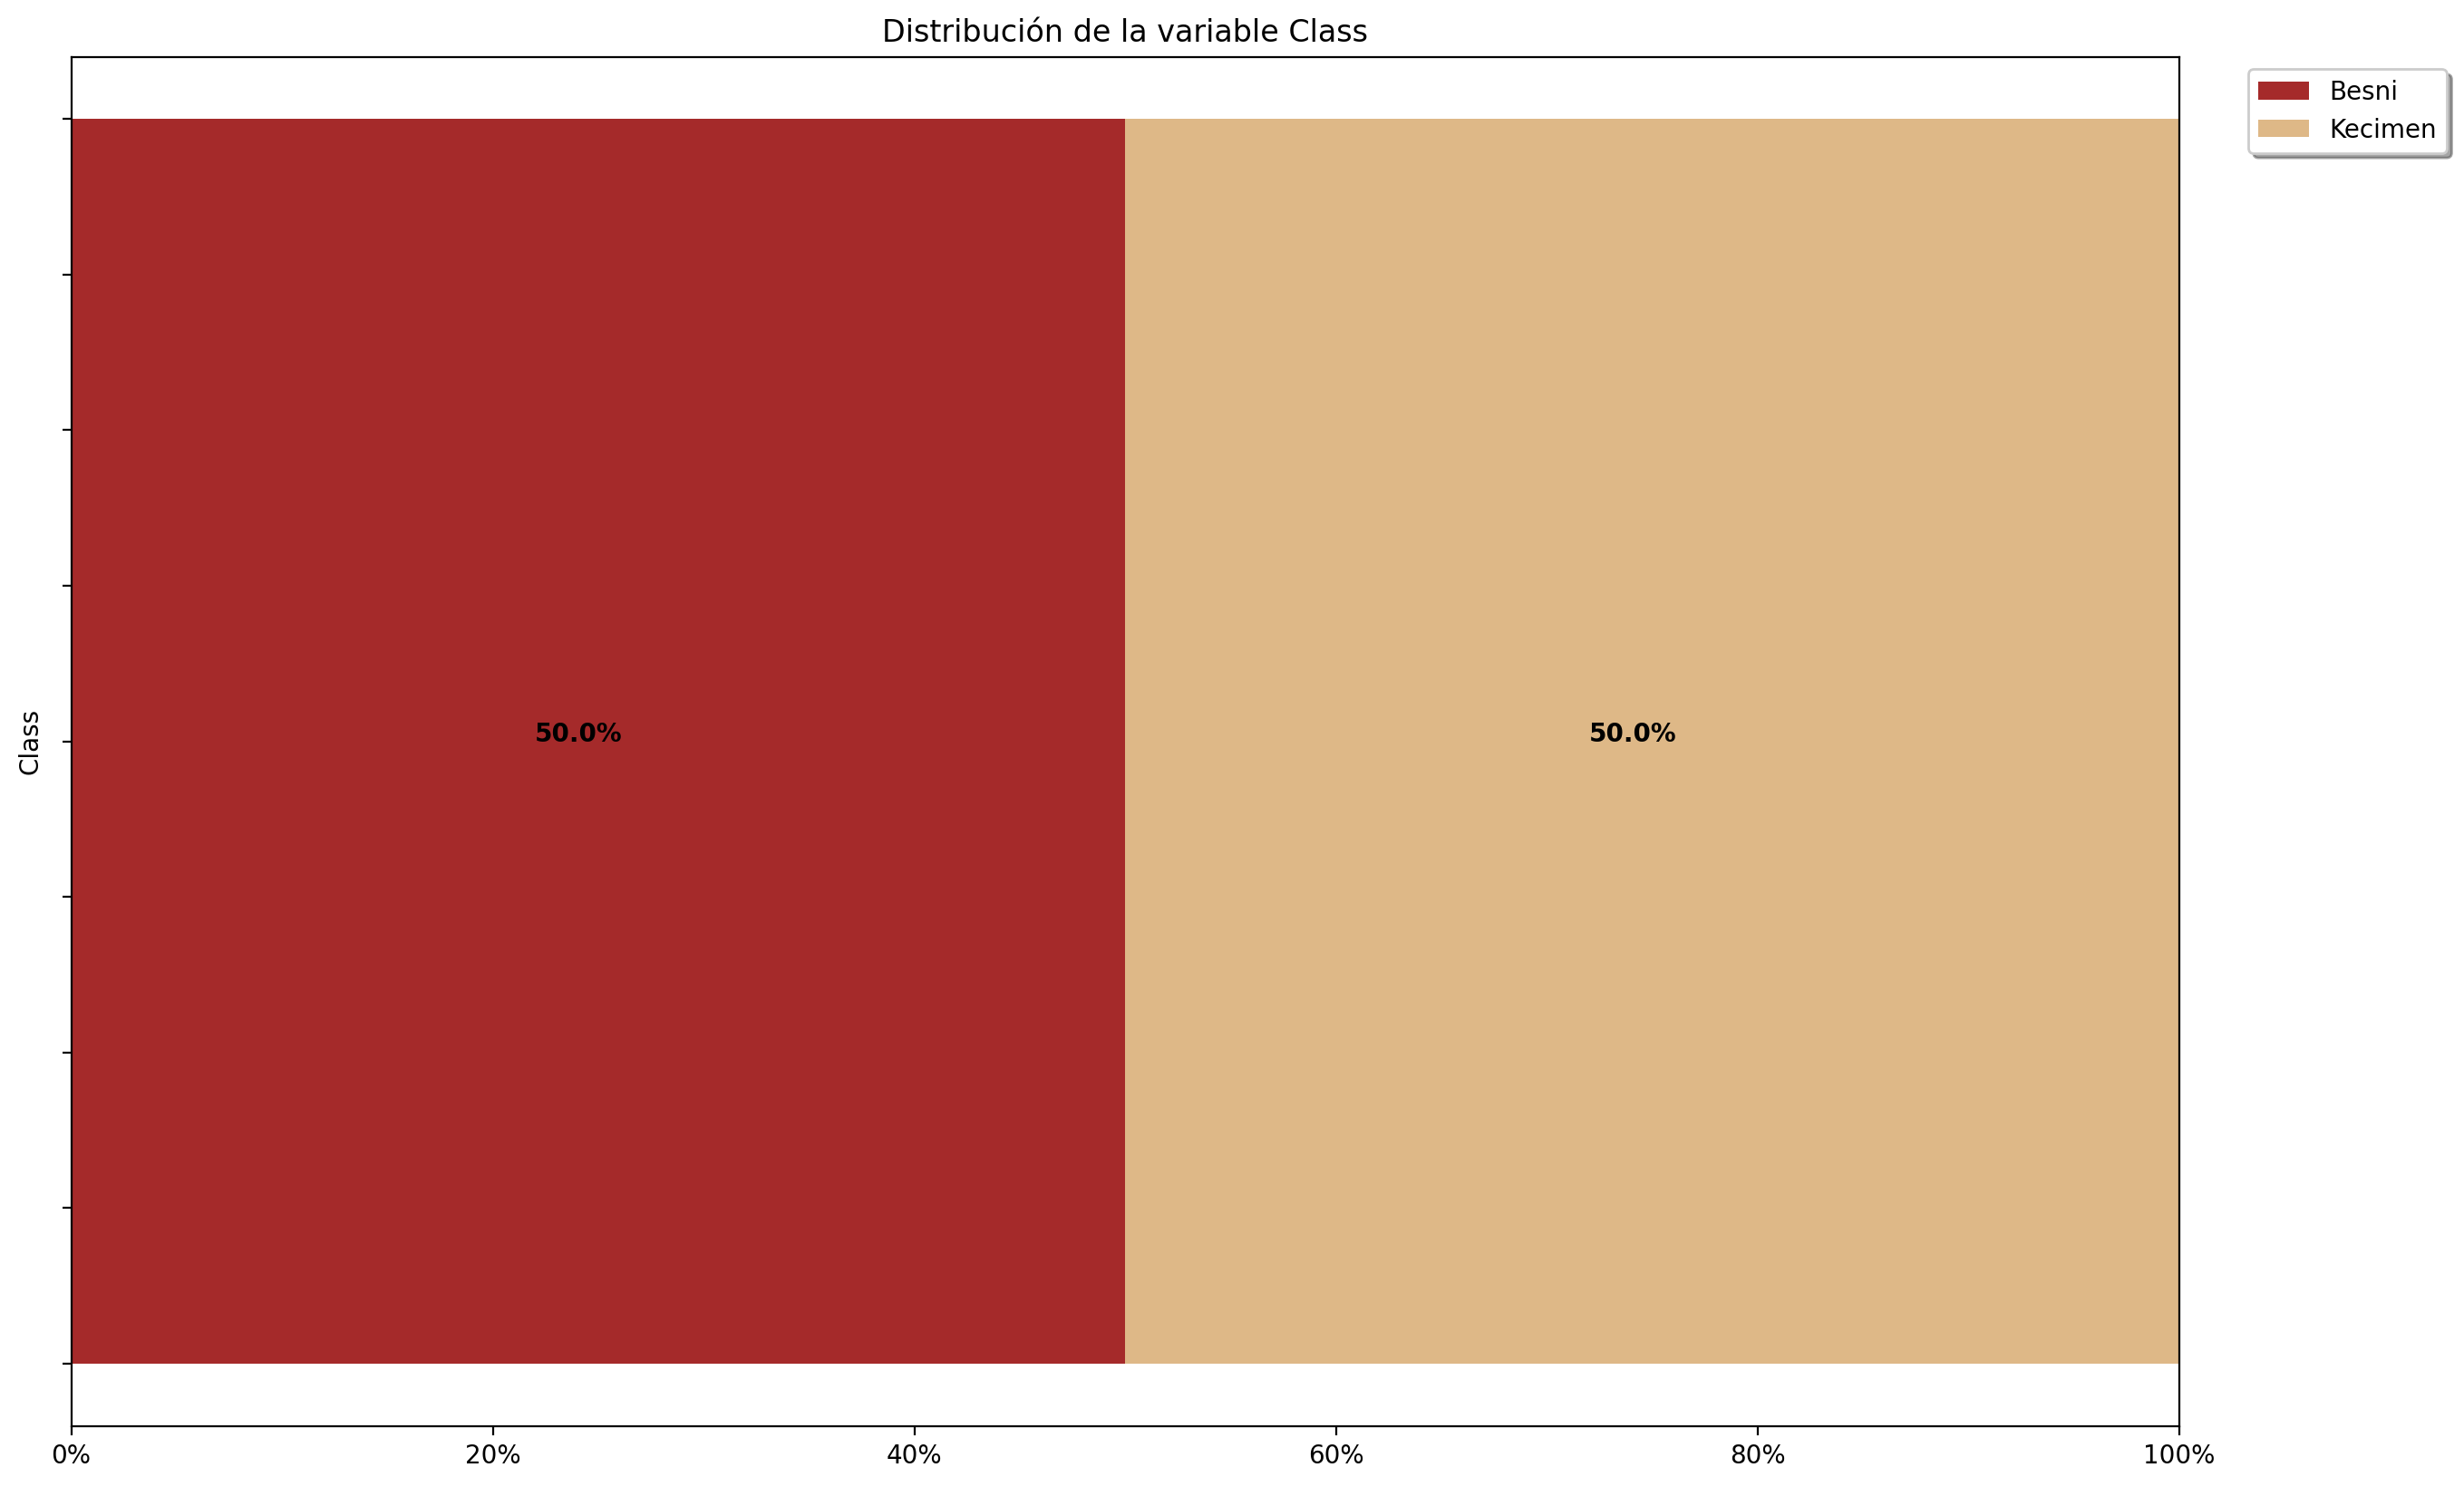

In [21]:
### Distribución de la variable de respuesta:
### Es un problema BALANCEADO
distribucion_variable_predecir(df_raisin,"Class")
plt.show()

In [22]:
### Calculamos los estadísticos básicos sobre cada columna numérica. Esto se puede hacer en pandas con un describe.
df_raisin.describe()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter
count,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000
mean,87804.127778,430.929950,254.488133,0.781542,91186.090000,0.699508,1165.906636
std,39002.111390,116.035121,49.988902,0.090318,40769.290132,0.053468,273.764315
min,25387.000000,225.629541,143.710872,0.348730,26139.000000,0.379856,619.074000
25%,59348.000000,345.442898,219.111126,0.741766,61513.250000,0.670869,966.410750
50%,78902.000000,407.803951,247.848409,0.798846,81651.000000,0.707367,1119.509000
75%,105028.250000,494.187014,279.888575,0.842571,108375.750000,0.734991,1308.389750
max,235047.000000,997.291941,492.275279,0.962124,278217.000000,0.835455,2697.753000


Observemos que las escalas de los datos son diferentes para todas las variables.

In [23]:
df_raisin_num = df_raisin.drop(['Class'],axis=1)
df_raisin_num.corr()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter
Area,1.000000,0.932774,0.906650,0.336107,0.995920,-0.013499,0.961352
MajorAxisLength,0.932774,1.000000,0.728030,0.583608,0.945031,-0.203866,0.977978
MinorAxisLength,0.906650,0.728030,1.000000,-0.027683,0.895651,0.145322,0.827417
Eccentricity,0.336107,0.583608,-0.027683,1.000000,0.348210,-0.361061,0.447845
ConvexArea,0.995920,0.945031,0.895651,0.348210,1.000000,-0.054802,0.976612
Extent,-0.013499,-0.203866,0.145322,-0.361061,-0.054802,1.000000,-0.173449
Perimeter,0.961352,0.977978,0.827417,0.447845,0.976612,-0.173449,1.000000


In [24]:
plt.rcParams["figure.figsize"] = (10,10)  ### Cambiar las dimensiones de la figura

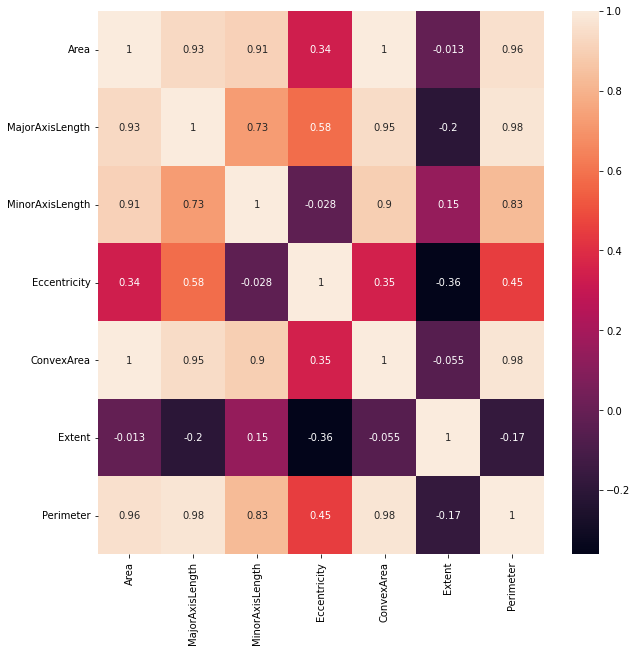

In [27]:
sn.heatmap(df_raisin_num.corr(), annot=True)
plt.show()

Cuidado! 
- Hay algunas variables que tienen una alta correlación, vea por ejemplo `ConvexArea` y `Area`, o `MajorAxisLength` y `Perimeter`.

**Veamos los gráficos de poder predictivo para darnos una idea de la relación de cada variable con la respuesta.**

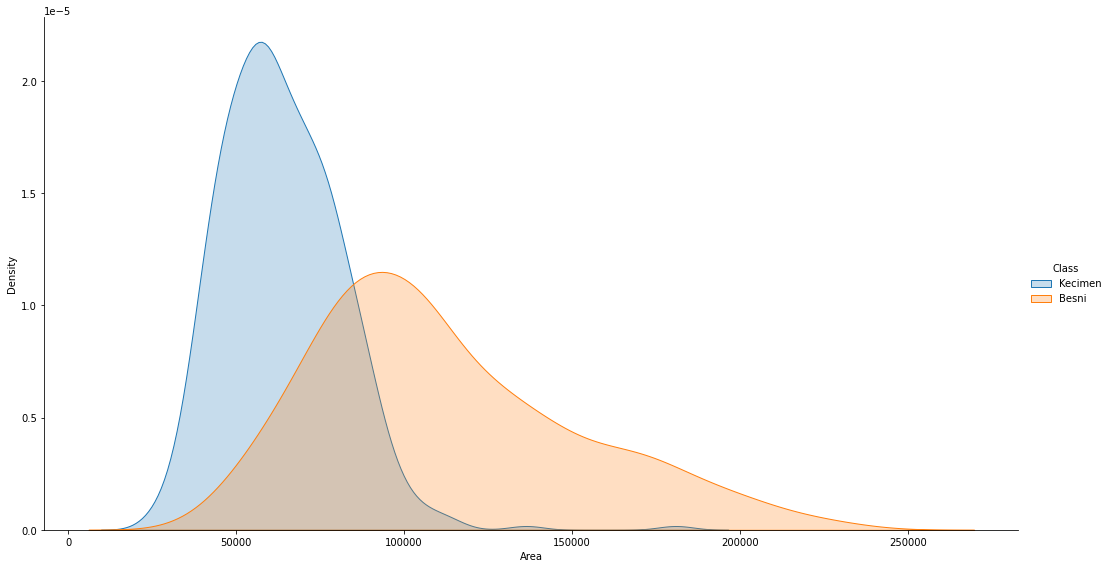

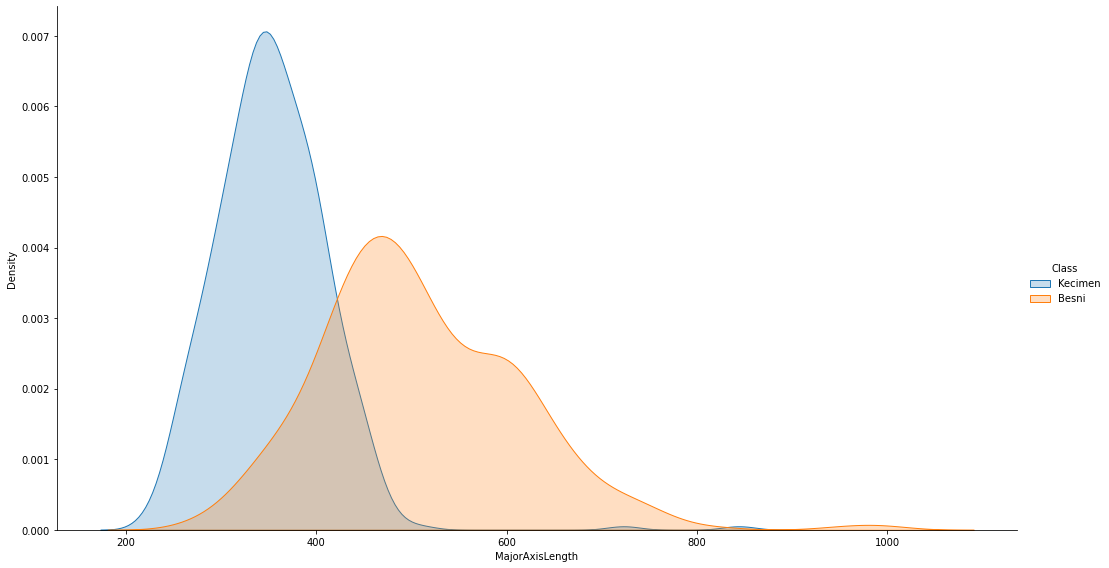

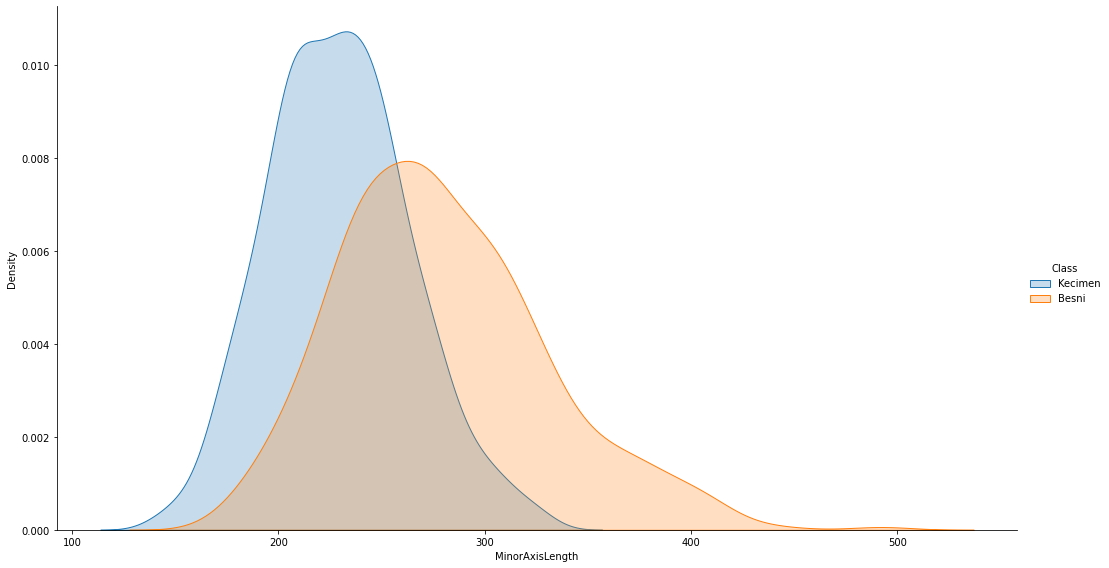

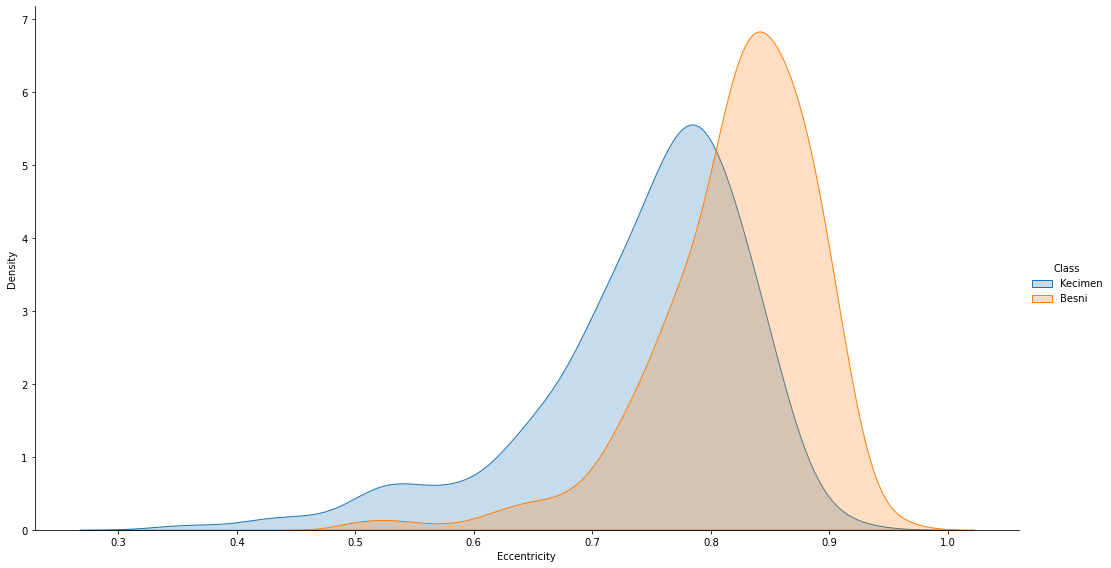

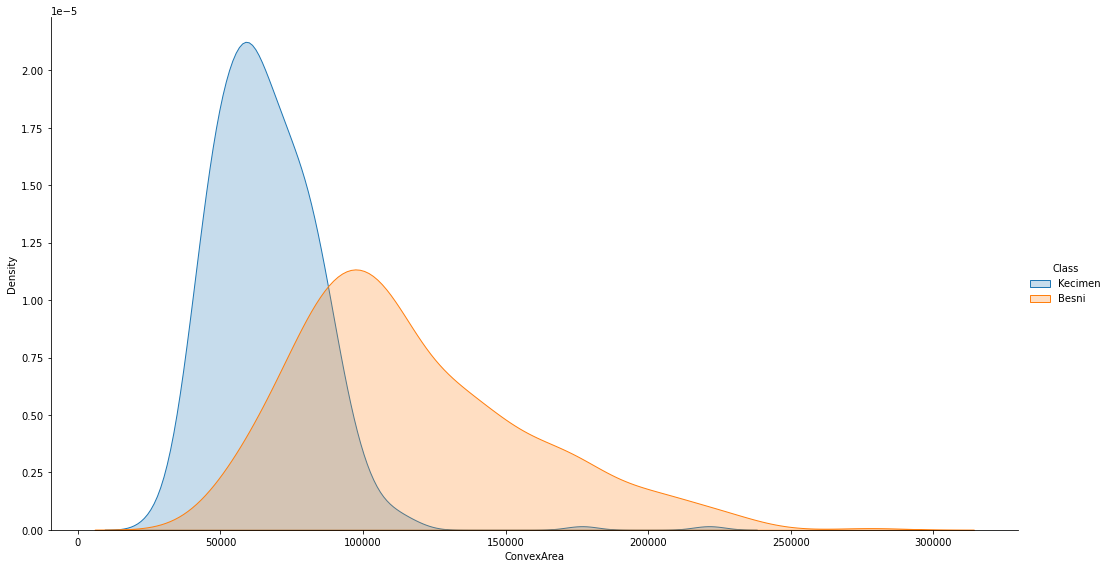

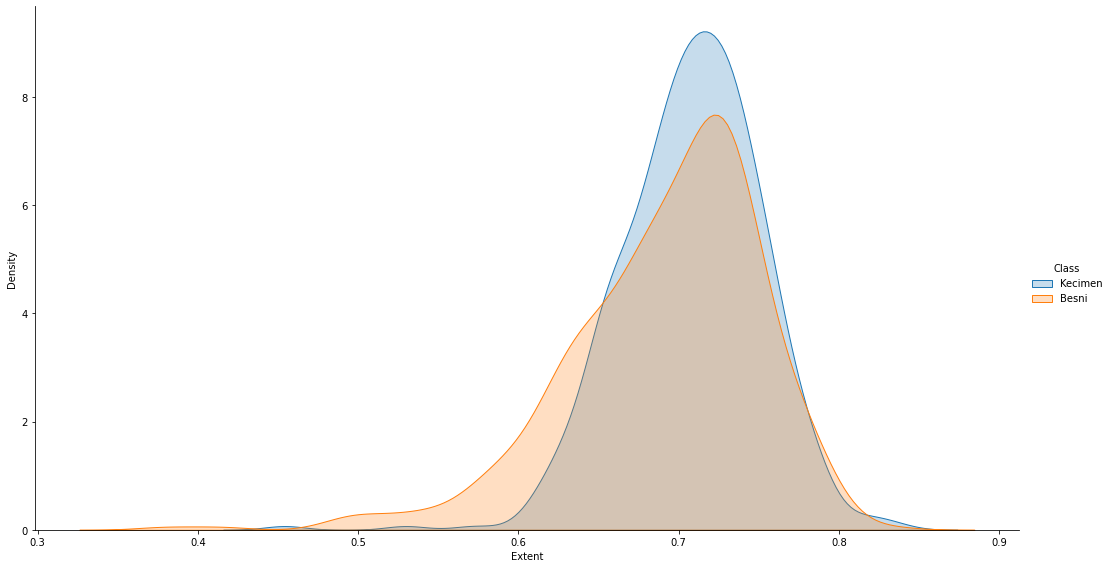

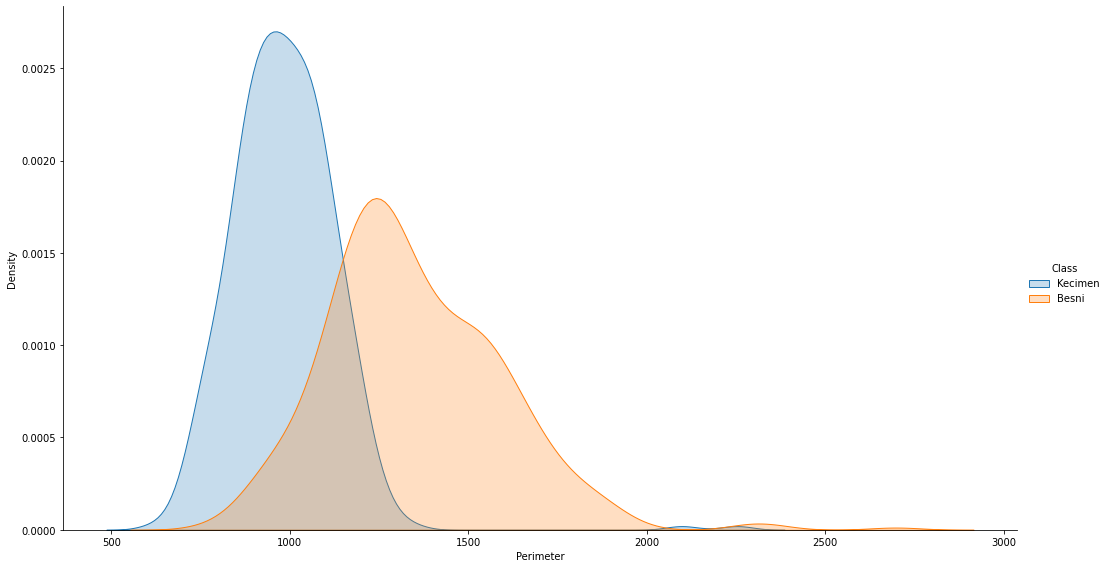

In [28]:
for col in df_raisin_num.columns:
    poder_predictivo_numerica(df_raisin,col,"Class")
    plt.show()

Algunas variables que discriminan mejor las clases de la respuesta podrían ser `Area`, `MajorAxisLength`, `ConvexArea` y `Perimeter`. Una en particular que no parece tener mucho poder predictivo es `Extent`.

#### Ajuste de KNN
A continuación ajustaremos varios modelos de KNN, variando el `k` y observando el comportamiento sobre los datos de prueba.

In [29]:
# Variable a predecir
y = df_raisin["Class"].ravel()

#Convertimos a Dummy algunas de las variables predictoras
X = df_raisin_num

#Estandarizamos los datos
X = pd.DataFrame(StandardScaler().fit_transform(X), columns=[X.columns])

#Partimos los datos en training-testing
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.75)

prec_globals = []

for k in range(1,11):
    
    print(f" Modelo de k vecinos para k = {k} :")
    
    instancia_knn = KNeighborsClassifier(n_neighbors=k)
    instancia_knn.fit(X_train.values,y_train)
    
    prediccion = instancia_knn.predict(X_test.values)

    labels = ["Kecimen","Besni"]
    MC = confusion_matrix(y_test, prediccion, labels=labels)

    indices = indices_general(MC,labels)
    prec_globals.append(indices['Precisión Global'])
    
    for r in indices:
        
        print("\n%s:\n%s"%(k,str(indices[r])))
        
    print("----------------------------------------------")

 Modelo de k vecinos para k = 1 :

1:
[[ 86  18]
 [ 20 101]]

1:
0.8311111111111111

1:
0.16888888888888887

1:
    Kecimen     Besni
0  0.826923  0.834711
----------------------------------------------
 Modelo de k vecinos para k = 2 :

2:
[[ 73  31]
 [ 11 110]]

2:
0.8133333333333334

2:
0.18666666666666665

2:
    Kecimen     Besni
0  0.701923  0.909091
----------------------------------------------
 Modelo de k vecinos para k = 3 :

3:
[[ 87  17]
 [ 21 100]]

3:
0.8311111111111111

3:
0.16888888888888887

3:
    Kecimen     Besni
0  0.836538  0.826446
----------------------------------------------
 Modelo de k vecinos para k = 4 :

4:
[[ 81  23]
 [ 16 105]]

4:
0.8266666666666667

4:
0.17333333333333334

4:
    Kecimen     Besni
0  0.778846  0.867769
----------------------------------------------
 Modelo de k vecinos para k = 5 :

5:
[[92 12]
 [22 99]]

5:
0.8488888888888889

5:
0.15111111111111108

5:
    Kecimen     Besni
0  0.884615  0.818182
------------------------------------

Con `k=10` obtuvimos la mayor precisión global y la mayor precisión en cada clase. \
Como es un problema balanceado, la precisión global es un criterio suficiente para evaluar al modelo. \
Finalmente nuestra precisión global es de 0.8622222, y en cada clase la precisión está entre 0.8 y 0.9 aproximadamente. \
Podríamos decir que es un modelo relativamente bueno 😀

In [30]:
prec_globals

[0.8311111111111111,
 0.8133333333333334,
 0.8311111111111111,
 0.8266666666666667,
 0.8488888888888889,
 0.8622222222222222,
 0.8622222222222222,
 0.8533333333333334,
 0.8577777777777778,
 0.8666666666666667]

In [230]:
max(prec_globals)

0.8888888888888888

Vamos a repetir este procedimiento, pero para ello vamos a escoger variables con el mejor poder predictivo. \
De los gráficos anteriores podríamos proponer intuitivamente que estas variables son `Area`, `MajorAxisLength`, `ConvexArea` y `Perimeter`.

In [31]:
### Solo seleccionamos las variables con alto poder predictivo.
### Lo ideal sería utilizar la misma partición del inciso anterior, para compararlos.

X_train2 = X_train[['Area', 'MajorAxisLength', 'ConvexArea', 'Perimeter']]
X_test2 = X_test[['Area', 'MajorAxisLength', 'ConvexArea', 'Perimeter']]
X_train2.head()

,Area,MajorAxisLength,ConvexArea,Perimeter
765,0.853656,1.228532,0.815918,0.922760
836,2.394069,4.472966,3.298577,4.335050
208,-1.237983,-1.478886,-1.237430,-1.468968
288,-0.343201,-0.165845,-0.361676,-0.344629
193,-0.206671,0.094889,-0.232365,-0.164260


In [32]:
prec_globals2 = []

for k in range(1,11):
    
    print(f" Modelo de k vecinos para k = {k} :")
    
    instancia_knn = KNeighborsClassifier(n_neighbors=k)
    instancia_knn.fit(X_train2.values,y_train)
    
    prediccion = instancia_knn.predict(X_test2.values)

    labels = ["Kecimen","Besni"]
    MC = confusion_matrix(y_test, prediccion, labels=labels)

    indices = indices_general(MC,labels)
    prec_globals2.append(indices['Precisión Global'])
    
    for r in indices:
        
        print("\n%s:\n%s"%(k,str(indices[r])))
        
    print("----------------------------------------------")

 Modelo de k vecinos para k = 1 :

1:
[[84 20]
 [25 96]]

1:
0.8

1:
0.19999999999999996

1:
    Kecimen     Besni
0  0.807692  0.793388
----------------------------------------------
 Modelo de k vecinos para k = 2 :

2:
[[ 77  27]
 [ 16 105]]

2:
0.8088888888888889

2:
0.19111111111111112

2:
    Kecimen     Besni
0  0.740385  0.867769
----------------------------------------------
 Modelo de k vecinos para k = 3 :

3:
[[93 11]
 [22 99]]

3:
0.8533333333333334

3:
0.1466666666666666

3:
    Kecimen     Besni
0  0.894231  0.818182
----------------------------------------------
 Modelo de k vecinos para k = 4 :

4:
[[ 86  18]
 [ 17 104]]

4:
0.8444444444444444

4:
0.15555555555555556

4:
    Kecimen     Besni
0  0.826923  0.859504
----------------------------------------------
 Modelo de k vecinos para k = 5 :

5:
[[94 10]
 [22 99]]

5:
0.8577777777777778

5:
0.14222222222222225

5:
    Kecimen     Besni
0  0.903846  0.818182
----------------------------------------------
 Modelo de k 

In [33]:
prec_globals2

[0.8,
 0.8088888888888889,
 0.8533333333333334,
 0.8444444444444444,
 0.8577777777777778,
 0.8577777777777778,
 0.8622222222222222,
 0.8622222222222222,
 0.8755555555555555,
 0.8755555555555555]

In [34]:
max(prec_globals2)

0.8755555555555555

Al hacer esta selección de variables mejoramos un poco nuestra precisión global, ahora siendo lo óptimo seleccionar un `k=10`

En lo que sigue calculamos el dataframe del inciso 6. Tendrá dos filas, una para cada modelo seleccionado de los dos incisos anteriores. En ambos lo óptimo fue seleccionar `k=5`.

In [35]:
df_inc_6 = pd.DataFrame({})

### modelo inciso 4. 

instancia_knn1 = KNeighborsClassifier(n_neighbors=9)
instancia_knn1.fit(X_train.values,y_train)
prediccion1 = instancia_knn1.predict(X_test.values)
MC1 = confusion_matrix(y_test, prediccion1, labels=labels)
indices1 = indices_general(MC1,labels)

### Uso la clase del ejercicio 2.
medidas1= MatConf(indices1['Matriz de Confusión']).dict_medidas
df1=pd.DataFrame({'Modelo':['Inciso 4']})
for key in list(medidas1.keys()):
    df1[key]=medidas1[key]
df_inc_6 = df_inc_6.append(df1)

### modelo inciso 5.

instancia_knn2 = KNeighborsClassifier(n_neighbors=9)
instancia_knn2.fit(X_train2.values,y_train)
prediccion2 = instancia_knn2.predict(X_test2.values)
MC2 = confusion_matrix(y_test, prediccion2, labels=labels)
indices2 = indices_general(MC2,labels)

### Uso la clase del ejercicio 2.
medidas2= MatConf(indices2['Matriz de Confusión']).dict_medidas
df2=pd.DataFrame({'Modelo':['Inciso 5']})
for key in list(medidas2.keys()):
    df2[key]=medidas2[key]
df_inc_6 = df_inc_6.append(df2)

df_inc_6

,Modelo,Precisión Global,Error Global,Precisión Positiva (PP),Precisión Negativa (PN),Proporción de Falsos Positivos (PFP),Proporción de Falsos Negativos (PFN),Asertividad Positiva (AP),Asertividad Negativa (AN)
0,Inciso 4,0.857778,0.142222,0.834711,0.884615,0.115385,0.165289,0.893805,0.821429
0,Inciso 5,0.875556,0.124444,0.842975,0.913462,0.086538,0.157025,0.918919,0.833333


En general vemos que el segundo modelo se ha comportado mejor en todos los indicadores. Esto, claro, puede depender de la partición que hemos hecho. No se ha realizado validación cruzada (no estaba en los enunciados) para eliminar la incertidumbre de la partición.

Finalmente, hacemos una comparación de los modelos con los tres núcleos posibles.

In [36]:
datos_nucleos = pd.DataFrame({'k':[],'nucleo':[],'precision_global':[]})
nucleos = ['auto','ball_tree', 'kd_tree', 'brute']

for k in range(1,11):
    for nucleo in nucleos:
        
        instancia_knn = KNeighborsClassifier(n_neighbors=k,algorithm=nucleo)
        instancia_knn.fit(X_train.values,y_train)
        
        prediccion = instancia_knn.predict(X_test.values)
        MC = confusion_matrix(y_test, prediccion, labels=labels)
        
        indices = indices_general(MC,labels)
        prec = indices['Precisión Global']
         
        datos_nucleos = datos_nucleos.append(pd.DataFrame({'k':[k],'nucleo':[nucleo],'precision_global':[prec]}))
        
datos_nucleos

,k,nucleo,precision_global
0,1.0,auto,0.831111
0,1.0,ball_tree,0.831111
0,1.0,kd_tree,0.831111
0,1.0,brute,0.831111
0,2.0,auto,0.813333
0,2.0,ball_tree,0.813333
0,2.0,kd_tree,0.813333
0,2.0,brute,0.813333
0,3.0,auto,0.831111
0,3.0,ball_tree,0.831111


<div class='question_container'>
    <h2> Pregunta 5 </h2>
    <p>En este ejercicio vamos a predecir números escritos a mano (Hand Written Digit Recognition), la tabla de aprendizaje está en el archivo `ZipDataTrainCod.csv` y la tabla de testing está en el archivo `ZipDataTestCod.csv`. En la figura siguiente se ilustran los datos: </p>
    <p> Los datos de este ejemplo vienen de los códigos postales escritos a mano en sobres del correo postal de EE.UU. Las imágenes son de 16 $\times$ 16 en escala de grises, cada pixel va de intensidad de -1 a 1 (de blanco a negro). Las imágenes se han normalizado para tener aproximadamente el mismo tamaño y orientación. La tarea consiste en predecir, a partir de la matriz de 16 $\times$ 16 de intensidades de cada pixel, la identidad de cada imagen (0, 1, ...,  9) de forma rápida y precisa. Si es lo suficientemente precisa, el algoritmo resultante se utiliza como parte de un procedimiento de selección automática para sobres. Este es un problema de clasificación para el cual la tasa de error debe mantenerse muy baja para evitar la mala dirección de correo. La columna 1 tiene la variable a predecir Número codificada como sigue: 0='cero'; 1='uno'; 2='dos'; 3='tres'; 4='cuatro'; 5='cinco';6='seis'; 7='siete'; 8='ocho' y 9='nueve', las demás columnas son las variables predictivas, además cada fila de la tabla representa un bloque 16 $\times$ 16 por lo que la matriz tiene 256 variables predictoras. </p>
    <ol>
        <li>Usando K vecinos más cercanos genere un modelo predictivo para la tabla de aprendizaje, con los parámetros que usted estime más convenientes.</li>
        <li>Con la tabla de testing calcule la matriz de confusión, la precisión global, el error global y la precisión en cada unos de los dígitos. ¿Son buenos los resultados?</li>
        <li>Repita los items 1) y 2) pero usando solamente los 1s, 6s y los 9s. ¿Mejora la predicción?</li>
        <li>Repita los items 1) y 2) utilizando n neighbors=5 y algorithm=`auto` (parámetros por defecto) pero reemplazando cada bloque 4 $\times$ 4 de píxeles por su promedio. ¿Mejora la predicción? Recuerde que cada bloque 16 $\times$ 16 está representado por una fila en las matrices de aprendizaje y testing. Despliegue la matriz de confusión resultante. La matriz de confusión obtenida debería ser: (Mostrada en la Tarea). No es necesario que las categorías se muestren en orden. </li>
        <li>Repita los items 1) y 2) pero reemplazando cada bloque p$\times$p de píxeles por su promedio. ¿Mejora la predicción? (pruebe con algunos valores de p). Despliegue las matrices de confusión resultantes.</li>
    </ol>
</div>

In [3]:
zipdata_train = pd.read_csv("ZipDataTrainCod.csv",sep=';')
zipdata_test = pd.read_csv("ZipDataTestCod.csv",sep=';')

In [4]:
zipdata_train.head(3)

,Numero,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257
0,seis,-1.0,-1.0,-1.0,-1.000,-1.000,-1.000,-1.000,-0.631,0.862,...,0.304,0.823,1.000,0.482,-0.474,-0.991,-1.000,-1.000,-1.000,-1.0
1,cinco,-1.0,-1.0,-1.0,-0.813,-0.671,-0.809,-0.887,-0.671,-0.853,...,-0.671,-0.671,-0.033,0.761,0.762,0.126,-0.095,-0.671,-0.828,-1.0
2,cuatro,-1.0,-1.0,-1.0,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,...,-1.000,-1.000,-1.000,-0.109,1.000,-0.179,-1.000,-1.000,-1.000,-1.0


In [5]:
zipdata_test.head(3)

,Numero,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257
0,nueve,-1.0,-1.0,-1.0,-1.000,-1.0,-0.948,-0.561,0.148,0.384,...,-1.0,-0.908,0.430,0.622,-0.973,-1.0,-1.0,-1.0,-1.0,-1.0
1,seis,-1.0,-1.0,-1.0,-1.000,-1.0,-1.000,-1.000,-1.000,-1.000,...,-1.0,-1.000,-1.000,-1.000,-1.000,-1.0,-1.0,-1.0,-1.0,-1.0
2,tres,-1.0,-1.0,-1.0,-0.593,0.7,1.000,1.000,1.000,1.000,...,1.0,0.717,0.333,0.162,-0.393,-1.0,-1.0,-1.0,-1.0,-1.0


In [6]:
X_train = zipdata_train.drop(['Numero'],axis=1)
y_train = zipdata_train['Numero']
X_test = zipdata_test.drop(['Numero'],axis=1)
y_test = zipdata_test['Numero']

In [7]:
instancia_knn = KNeighborsClassifier(n_neighbors=5,algorithm='auto')
instancia_knn.fit(X_train.values,y_train)
prediccion = instancia_knn.predict(X_test.values)

In [10]:
mat_cfn = confusion_matrix(y_test, prediccion)
mat_cfn

array([[354,   0,   0,   3,   1,   0,   1,   0,   0,   0],
       [  5, 146,   0,   1,   3,   1,   0,   0,   4,   0],
       [  0,   0, 184,   1,   8,   0,   2,   2,   0,   3],
       [  7,   0,   1, 182,   0,   4,   1,   2,   1,   0],
       [  1,   1,   3,   0, 169,   0,   0,   3,   0,   0],
       [  5,   3,   0,   0,   2, 153,   0,   1,   2,   0],
       [  3,   0,   2,   2,   0,   1, 162,   0,   0,   0],
       [  0,   1,   4,   1,   1,   1,   0, 137,   0,   2],
       [  2,   7,   0,   1,   2,   1,   0,   1, 152,   0],
       [  0,   0,   4,   0,   0,   0,   2,   0,   0, 258]], dtype=int64)

Esta es la matriz de confusión para el modelo.

In [12]:
plt.rcParams["figure.figsize"] = (10,10)  ### Cambiar las dimensiones de la figura

C:\Users\jimmy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\jimmy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


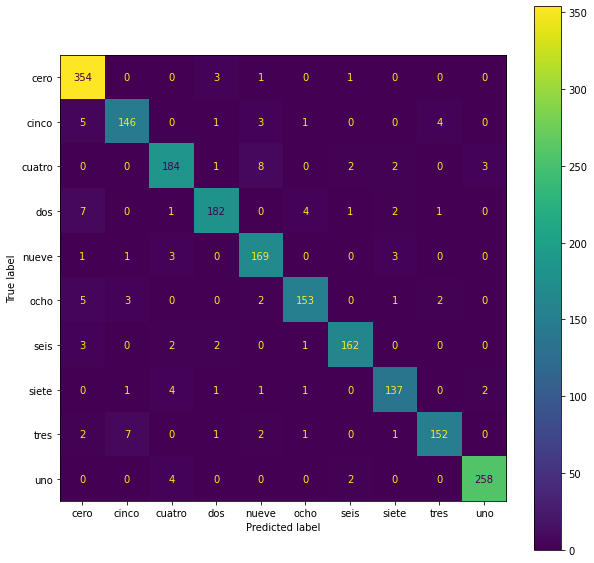

In [13]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(instancia_knn, X_test, y_test)

Para esta matriz de confusión vamos a calcular la precisión global, el error global y la precisión para cada uno de los dígitos

In [39]:
def get_prec_multi(mat_cfn, labels):
    suma_total = sum(sum(mat_cfn))
    suma_diag = sum([mat_cfn[i,i] for i in range(mat_cfn.shape[0])])
    prec_global = suma_diag/suma_total
    err_global = 1- prec_global
    prec_digitos={} ### Creamos un diccionario con la precisión de cada dígito.
    prec_digitos['Precisión Global']=prec_global
    prec_digitos['Error Global']=err_global
    for i in range(mat_cfn.shape[0]):
        prec_este_digito = mat_cfn[i,i]/sum([mat_cfn[i,j] for j in range(mat_cfn.shape[0])])
        prec_digitos[f'Precisión "{labels[i]}"']= prec_este_digito
    return prec_digitos

In [40]:
labels_dig=['cero','cinco','cuatro','dos','nueve','ocho','seis','siete','tres','uno']
get_prec_multi(mat_cfn, labels_dig)

{'Precisión Global': 0.9451918285999004,
 'Error Global': 0.05480817140009964,
 'Precisión "cero"': 0.9860724233983287,
 'Precisión "cinco"': 0.9125,
 'Precisión "cuatro"': 0.92,
 'Precisión "dos"': 0.9191919191919192,
 'Precisión "nueve"': 0.9548022598870056,
 'Precisión "ocho"': 0.9216867469879518,
 'Precisión "seis"': 0.9529411764705882,
 'Precisión "siete"': 0.9319727891156463,
 'Precisión "tres"': 0.9156626506024096,
 'Precisión "uno"': 0.9772727272727273}

Inciso 3: solo con los 1's, 6's y 9's.

In [30]:
zipdata_train3 = zipdata_train[zipdata_train['Numero'].isin(['uno','seis','nueve'])]
zipdata_test3 = zipdata_test[zipdata_test['Numero'].isin(['uno','seis','nueve'])]
zipdata_train3.head(10)

,Numero,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257
0,seis,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000,-1.000,-0.631,0.862,...,0.304,0.823,1.000,0.482,-0.474,-0.991,-1.0,-1.0,-1.0,-1.0
5,seis,-1.0,-1.0,-1.0,-1.0,-1.0,-0.397,0.983,-0.535,-1.000,...,0.803,0.015,-0.862,-0.871,-0.437,-1.000,-1.0,-1.0,-1.0,-1.0
7,uno,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000,-1.000,0.510,-0.213,...,-0.654,0.666,0.301,-1.000,-1.000,-1.000,-1.0,-1.0,-1.0,-1.0
9,uno,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000,-1.000,-0.909,0.801,...,-1.000,-0.332,0.735,0.380,-1.000,-1.000,-1.0,-1.0,-1.0,-1.0
12,uno,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000,-0.998,0.613,-0.385,...,-0.968,0.192,0.159,-1.000,-1.000,-1.000,-1.0,-1.0,-1.0,-1.0
13,uno,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000,-1.000,0.457,-0.219,...,-1.000,-0.086,0.804,-0.953,-1.000,-1.000,-1.0,-1.0,-1.0,-1.0
19,uno,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000,0.254,0.241,-0.929,...,-1.000,-0.399,0.077,-1.000,-1.000,-1.000,-1.0,-1.0,-1.0,-1.0
29,uno,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000,-1.000,-0.582,0.849,...,-0.966,0.624,0.706,-0.819,-1.000,-1.000,-1.0,-1.0,-1.0,-1.0
31,seis,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000,-1.000,-1.000,-0.270,...,-0.041,0.628,0.573,-0.184,-0.891,-1.000,-1.0,-1.0,-1.0,-1.0
34,uno,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000,-0.766,0.960,-0.528,...,-0.986,0.388,0.692,-0.984,-1.000,-1.000,-1.0,-1.0,-1.0,-1.0


In [31]:
X_train3 = zipdata_train3.drop(['Numero'],axis=1)
y_train3 = zipdata_train3['Numero']
X_test3 = zipdata_test3.drop(['Numero'],axis=1)
y_test3 = zipdata_test3['Numero']

In [32]:
instancia_knn3 = KNeighborsClassifier(n_neighbors=5,algorithm='auto')
instancia_knn3.fit(X_train3.values,y_train3)
prediccion3 = instancia_knn3.predict(X_test3.values)

In [33]:
mat_cfn3 = confusion_matrix(y_test3, prediccion3)
mat_cfn3

array([[177,   0,   0],
       [  2, 168,   0],
       [  3,   2, 259]], dtype=int64)

C:\Users\jimmy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\jimmy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


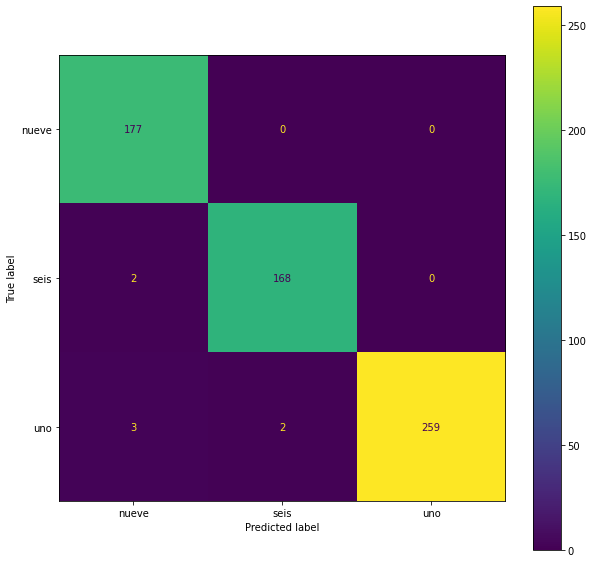

In [41]:
plot_confusion_matrix(instancia_knn3, X_test3, y_test3)

In [43]:
get_prec_multi(mat_cfn3, labels=['nueve','seis','uno'])

{'Precisión Global': 0.9885433715220949,
 'Error Global': 0.011456628477905073,
 'Precisión "nueve"': 1.0,
 'Precisión "seis"': 0.9882352941176471,
 'Precisión "uno"': 0.9810606060606061}

En este caso vemos que la predicción ha mejorado, por ejemplo, los 'nueve' han sido predichos perfectamente.

Ahora queremos hacer bloques de $4\times 4$ para correr el algoritmo de knn sobre estos nuevos tipos de datos. Lo que debemos hacer es reagrupar los datos y crear nuevas variables, que sean los promedios de los valores de los pixeles en cada bloque.

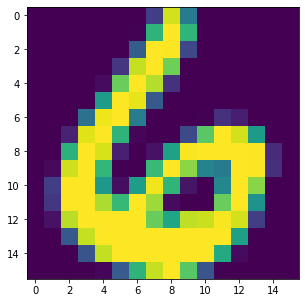

In [98]:
primer_numero=X_train.iloc[0].tolist()
x = np.array(primer_numero)
x = x.reshape(16, 16)
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(x)
plt.show()

Lo que sucede acá es que cada fila del dataframe, es la concatenación de las 16 filas que conforman al número.
Para agrupar por bloques de $4 \times 4$ debemos hacer un recorrido especial. Para ello utilizaré la función que transforma una fila en una matriz (El `reshape` de numpy, y luego crearé los bloques, todo está en esta función que sigue).

In [172]:
def hacer_bloques(data,p):
    
    data_dim = int(math.sqrt(data.shape[1]))
    
    if data_dim % p == 0:
        
        q = int(data_dim / p)
        data_blocked = {}
        for i in range(q):
            for j in range(q):
                data_blocked[f'V{i}_{j}']=[]
        data_blocked = pd.DataFrame({})
        
        for r in range(data.shape[0]):
            ### Hacer un bloque de cada fila ###
            fila=data.iloc[r].tolist()
            x = np.array(fila)
            x = x.reshape(data_dim, data_dim)
            data_blocked_fila={}
            for i in range(q):
                for j in range(q):
                    
                    bloque=[]
                    for k in range(p):
                        bloque.append(x[p*i+k][p*j:p*(j+1)])
                    bloque=np.array([bloque])
                    
                    mean_bloque = np.mean(bloque)
                    data_blocked_fila[f'V_{i}_{j}']=[mean_bloque]
                    
            data_blocked_fila = pd.DataFrame(data_blocked_fila)
            data_blocked = data_blocked.append(data_blocked_fila, ignore_index=True)
                
        return data_blocked
    else:
        raise Exception("No se pueden hacer bloques de este tamaño")

Hagámoslo con bloques de $4 \times 4$

In [173]:
data_bloques=hacer_bloques(data=X_train,p=4)
data_bloques.head()

,V_0_0,V_0_1,V_0_2,V_0_3,V_1_0,V_1_1,V_1_2,V_1_3,V_2_0,V_2_1,V_2_2,V_2_3,V_3_0,V_3_1,V_3_2,V_3_3
0,-1.000000,-0.474625,-0.375938,-1.000000,-0.821562,0.193125,-0.717812,-0.804563,-0.008250,-0.009563,0.027188,-0.051063,-0.576125,0.692063,0.627938,-0.785875
1,-0.859687,0.531687,0.310500,-0.038937,-0.833000,0.475688,0.214625,-0.871188,-0.000250,-0.895750,-0.811813,0.244750,-0.182938,0.228562,0.386750,0.313188
2,-1.000000,-0.987500,-0.138437,-0.937500,-0.733625,-0.354875,0.047500,-0.998563,-0.616125,0.111375,0.332375,-0.601938,-1.000000,-0.900687,0.170062,-1.000000
3,-0.869625,0.109812,0.074312,-0.647687,-0.667375,-0.701563,-0.093875,-0.848375,-1.000000,-0.911438,-0.075313,-1.000000,-1.000000,-0.403062,-0.557000,-1.000000
4,-1.000000,0.025062,0.063688,-1.000000,-1.000000,-0.238063,0.320750,-0.984812,-0.895563,-0.882188,-0.735688,-0.188812,-0.203000,0.169000,0.037375,-0.145812


In [174]:
data_bloques.shape

(7291, 16)

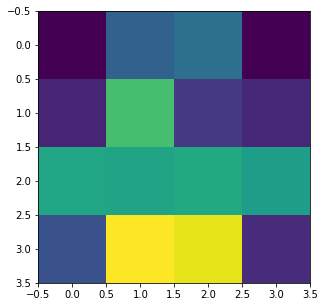

In [161]:
primer_numero=data_bloques.iloc[0].tolist()
x = np.array(primer_numero)
x = x.reshape(4, 4)
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(x)
plt.show()

Parece que los bloques de 4 no son muy informativos. Vamos a ver qué sucede con el clasificador en este caso.

In [182]:
X_train_p4= hacer_bloques(data=X_train,p=4)
X_test_p4= hacer_bloques(data=X_test,p=4)
y_train_p4= zipdata_train['Numero']
y_test_p4= zipdata_test['Numero']

In [183]:
X_train_p4

,V_0_0,V_0_1,V_0_2,V_0_3,V_1_0,V_1_1,V_1_2,V_1_3,V_2_0,V_2_1,V_2_2,V_2_3,V_3_0,V_3_1,V_3_2,V_3_3
0,-1.000000,-0.474625,-0.375938,-1.000000,-0.821562,0.193125,-0.717812,-0.804563,-0.008250,-0.009563,0.027188,-0.051063,-0.576125,0.692063,0.627938,-0.785875
1,-0.859687,0.531687,0.310500,-0.038937,-0.833000,0.475688,0.214625,-0.871188,-0.000250,-0.895750,-0.811813,0.244750,-0.182938,0.228562,0.386750,0.313188
2,-1.000000,-0.987500,-0.138437,-0.937500,-0.733625,-0.354875,0.047500,-0.998563,-0.616125,0.111375,0.332375,-0.601938,-1.000000,-0.900687,0.170062,-1.000000
3,-0.869625,0.109812,0.074312,-0.647687,-0.667375,-0.701563,-0.093875,-0.848375,-1.000000,-0.911438,-0.075313,-1.000000,-1.000000,-0.403062,-0.557000,-1.000000
4,-1.000000,0.025062,0.063688,-1.000000,-1.000000,-0.238063,0.320750,-0.984812,-0.895563,-0.882188,-0.735688,-0.188812,-0.203000,0.169000,0.037375,-0.145812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7286,-0.854437,0.637375,0.357000,-0.967375,-1.000000,-0.767750,0.365125,-0.996875,-0.955375,-0.309563,0.132625,-0.757437,-0.880562,0.320063,0.131625,-0.976750
7287,-0.981437,0.179000,-0.028625,-1.000000,-1.000000,-0.686937,0.449500,-1.000000,-1.000000,-0.681312,0.398062,-0.960938,-0.992062,0.413250,-0.019062,-1.000000
7288,-0.512062,0.561813,0.824500,-0.637750,-0.980313,-0.647375,0.697625,-0.761813,-0.863437,-0.600250,0.155438,-0.295813,-0.785125,0.599250,0.676125,-0.832250
7289,-0.897938,0.652687,0.769000,-0.689937,0.051688,0.787000,0.502938,0.386000,0.496375,0.126250,-0.066937,0.603813,-0.626812,0.627125,0.731625,-0.330000


In [184]:
instancia_knn_p4 = KNeighborsClassifier(n_neighbors=5,algorithm='auto')
instancia_knn_p4.fit(X_train_p4.values,y_train_p4)
prediccion_p4 = instancia_knn_p4.predict(X_test_p4.values)

In [185]:
mat_cfn_p4 = confusion_matrix(y_test_p4, prediccion_p4)
mat_cfn_p4

array([[343,   0,   0,   2,   0,   4,   3,   1,   0,   6],
       [ 10, 123,   0,   1,   3,   5,   0,   1,  17,   0],
       [  0,   1, 166,   4,  22,   1,   2,   0,   0,   4],
       [  5,   1,   0, 180,   1,   6,   0,   1,   1,   3],
       [  1,   0,   2,   0, 172,   1,   0,   1,   0,   0],
       [  9,   5,   1,   2,   2, 124,   2,   0,   2,  19],
       [  6,   2,   2,   2,   0,   0, 157,   0,   0,   1],
       [  0,   0,   7,   2,   7,   1,   0, 130,   0,   0],
       [  2,  15,   0,   3,   2,   4,   0,   1, 138,   1],
       [  1,   1,   5,   1,   0,   2,   1,   3,   0, 250]], dtype=int64)

C:\Users\jimmy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\jimmy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


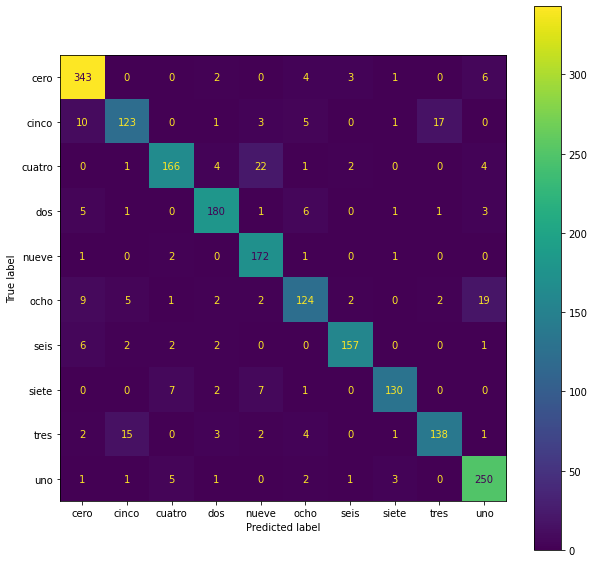

In [186]:
plot_confusion_matrix(instancia_knn_p4, X_test_p4, y_test_p4)

Observe que es la misma matriz que se muestra en la tarea, con un orden distinto de los dígitos. Veamos la predicción:

In [187]:
get_prec_multi(mat_cfn_p4, labels_dig)

{'Precisión Global': 0.8883906327852517,
 'Error Global': 0.11160936721474835,
 'Precisión "cero"': 0.9554317548746518,
 'Precisión "cinco"': 0.76875,
 'Precisión "cuatro"': 0.83,
 'Precisión "dos"': 0.9090909090909091,
 'Precisión "nueve"': 0.9717514124293786,
 'Precisión "ocho"': 0.7469879518072289,
 'Precisión "seis"': 0.9235294117647059,
 'Precisión "siete"': 0.8843537414965986,
 'Precisión "tres"': 0.8313253012048193,
 'Precisión "uno"': 0.946969696969697}

Como lo suponíamos, la precisión global ha disminuido. Algo intermedio se puede obtener con otro p.

Ahora intentemos con bloques de $2\times 2$. Estos se deberían de ver así:

In [189]:
X_train_p2= hacer_bloques(data=X_train,p=2)
X_test_p2= hacer_bloques(data=X_test,p=2)
y_train_p2= zipdata_train['Numero']
y_test_p2= zipdata_test['Numero']

In [190]:
X_train_p2.head()

,V_0_0,V_0_1,V_0_2,V_0_3,V_0_4,V_0_5,V_0_6,V_0_7,V_1_0,V_1_1,...,V_6_6,V_6_7,V_7_0,V_7_1,V_7_2,V_7_3,V_7_4,V_7_5,V_7_6,V_7_7
0,-1.0,-1.00000,-1.00000,-0.58150,0.50050,-1.00000,-1.00000,-1.00000,-1.0,-1.0000,...,-0.15775,-1.00000,-1.00000,-0.87075,0.1025,0.78175,0.87050,-0.06150,-0.98575,-1.00000
1,-1.0,-0.60525,0.09425,0.04225,-0.10875,-0.07525,0.46800,-0.46125,-1.0,-0.8335,...,0.78575,0.69400,-1.00000,-0.76800,-0.1770,0.16450,0.68200,0.72200,0.30850,-0.53550
2,-1.0,-1.00000,-1.00000,-1.00000,-0.96950,0.63425,-0.75000,-1.00000,-1.0,-1.0000,...,-1.00000,-1.00000,-1.00000,-1.00000,-1.0000,-1.00000,-0.52125,0.55225,-1.00000,-1.00000
3,-1.0,-1.00000,-0.10325,0.82375,0.59425,-0.07875,-0.84925,-1.00000,-1.0,-0.4785,...,-1.00000,-1.00000,-1.00000,-1.00000,-1.0000,0.33350,-0.14700,-1.00000,-1.00000,-1.00000
4,-1.0,-1.00000,-0.38975,0.63675,0.67500,-0.51375,-1.00000,-1.00000,-1.0,-1.0000,...,0.64300,-0.39075,-0.98975,-0.27950,0.4620,0.77625,1.00000,0.80750,0.12525,-0.96075


In [191]:
instancia_knn_p2 = KNeighborsClassifier(n_neighbors=5,algorithm='auto')
instancia_knn_p2.fit(X_train_p2.values,y_train_p2)
prediccion_p2 = instancia_knn_p2.predict(X_test_p2.values)

In [192]:
mat_cfn_p2 = confusion_matrix(y_test_p2, prediccion_p2)
mat_cfn_p2

array([[355,   0,   0,   3,   1,   0,   0,   0,   0,   0],
       [  3, 147,   0,   2,   4,   1,   0,   0,   2,   1],
       [  0,   0, 190,   3,   3,   0,   0,   2,   0,   2],
       [  6,   0,   1, 179,   0,   6,   2,   2,   2,   0],
       [  1,   0,   2,   1, 170,   1,   0,   1,   0,   1],
       [  4,   4,   0,   0,   4, 150,   0,   0,   2,   2],
       [  1,   0,   2,   2,   0,   1, 164,   0,   0,   0],
       [  0,   1,   3,   0,   4,   2,   0, 135,   2,   0],
       [  3,   7,   0,   2,   1,   0,   0,   1, 152,   0],
       [  0,   0,   3,   0,   0,   0,   2,   0,   0, 259]], dtype=int64)

C:\Users\jimmy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\jimmy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


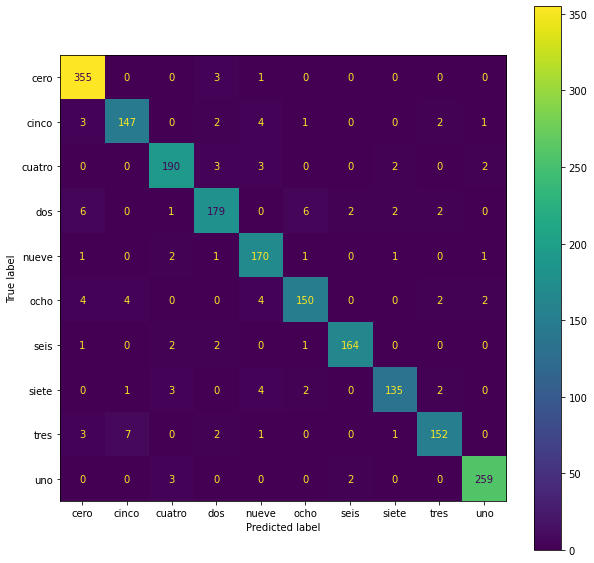

In [193]:
plot_confusion_matrix(instancia_knn_p2, X_test_p2, y_test_p2)

In [194]:
get_prec_multi(mat_cfn_p2, labels_dig)

{'Precisión Global': 0.9471848530144494,
 'Error Global': 0.052815146985550565,
 'Precisión "cero"': 0.9888579387186629,
 'Precisión "cinco"': 0.91875,
 'Precisión "cuatro"': 0.95,
 'Precisión "dos"': 0.9040404040404041,
 'Precisión "nueve"': 0.96045197740113,
 'Precisión "ocho"': 0.9036144578313253,
 'Precisión "seis"': 0.9647058823529412,
 'Precisión "siete"': 0.9183673469387755,
 'Precisión "tres"': 0.9156626506024096,
 'Precisión "uno"': 0.9810606060606061}

Tenemos una precisión parecida a la inicial. Vea que aquí los dígitos tienen una forma más definida.

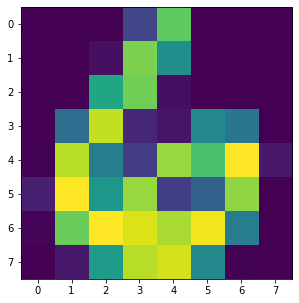

In [195]:
primer_numero=X_train_p2.iloc[0].tolist()
x = np.array(primer_numero)
x = x.reshape(8, 8)
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(x)
plt.show()